In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the Excel file
df = pd.read_excel('Координаты движения мыши.xlsx').loc[0:10000]
df.to_excel('Координаты движения мыши  mini.xlsx')

In [2]:
import pandas as pd
df_new = pd.read_excel(r'Координаты движения мыши Unix mini.xlsx')
df_new

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,ACCOUNT_ID,CREATED,Кол-во координат,Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
0,0,0,0,102186,xpaxxp9p,2023-07-20 21:19:14,423,"932,519,1689877037886;989,505,1689877037896;10..."
1,1,1,1,102187,xxaxxxd3,2023-07-20 21:19:32,386,"431,296,1689877068175;427,297,1689877068191;42..."
2,2,2,2,102188,xapxxpp3,2023-07-20 21:20:20,363,"268,5,1689877172857;312,25,1689877172859;404,6..."
3,3,3,3,102189,x93xxxmd,2023-07-20 21:20:42,318,"360,10,1689877191611;359,26,1689877191612;359,..."
4,4,4,4,102190,xxmxx9xp,2023-07-20 21:21:02,592,"1076,254,1689877218456;1081,257,1689877218472;..."
...,...,...,...,...,...,...,...,...
1996,1996,1996,1996,104182,xlvxxxdv,2023-07-21 06:50:53,483,"193,496,1689911379067;242,482,1689911379083;28..."
1997,1997,1997,1997,104183,xpdxx9qx,2023-07-21 06:50:59,291,"630,7,1689911366172;633,32,1689911366191;639,6..."
1998,1998,1998,1998,104184,xdqxxp9x,2023-07-21 06:51:02,169,"128,12,1689910320727;153,47,1689910320731;216,..."
1999,1999,1999,1999,104185,xadxxppx,2023-07-21 06:51:02,232,"787,731;756,744;725,756;632,804;577,835;504,87..."


In [4]:
import pandas as pd
import numpy as np

def remove_last_number_and_semicolon(line):
    if isinstance(line, str):
        num_digits = count_digits_before_last_semicolon(line)
        if line.endswith(","):
            line = line[:-1]  # Remove the last semicolon
        last_comma_index = line.rfind(",")  # Find the last comma index
        if last_comma_index != -1 and line[last_comma_index:].count(";") == 1:
            line = line[:last_comma_index + num_digits + 1]  # Remove the last number and last semicolon

        # Remove comma if it is the last symbol in the line
        if line.endswith(","):
            line = line[:-1]

    return line

def count_digits_before_last_semicolon(line):
    if isinstance(line, str):
        last_semicolon_index = line.rfind(";")
        if last_semicolon_index == -1:
            return 0  # If there is no semicolon in the line, return 0

        before_semicolon = line[:last_semicolon_index]
        last_comma_index = before_semicolon.rfind(",")
        if last_comma_index == -1:
            return 0  # If there is no comma before the last semicolon, return 0

        number_before_semicolon = before_semicolon[last_comma_index + 1:]
        num_digits = sum(1 for char in number_before_semicolon if char.isdigit())
        return num_digits

    return 0  # If the input is not a string, return 0

def calculate_speeds(unix_timestamps, x_coords, y_coords):
    speeds = []
    for i in range(1, len(unix_timestamps)):
        time_diff = (unix_timestamps[i] - unix_timestamps[i - 1]) / 1000.0  # Convert to seconds
        distance = np.sqrt((x_coords[i] - x_coords[i - 1]) ** 2 + (y_coords[i] - y_coords[i - 1]) ** 2)
        speed = distance / time_diff
        speeds.append(speed)
    return speeds

def calculate_accelerations(unix_timestamps, speeds):
    accelerations = []
    for i in range(1, len(unix_timestamps) - 1):
        time_diff = (unix_timestamps[i + 1] - unix_timestamps[i - 1]) / 1000.0  # Convert to seconds
        acceleration = (speeds[i] - speeds[i - 1]) / time_diff
        accelerations.append(acceleration)
    return accelerations

def process_unix_column(df, col_name):
    df['Avg_Speed_unix'] = np.nan
    df['Avg_Accelerate_unix'] = np.nan

    for index, cell_value in enumerate(df[col_name]):
        if pd.isnull(cell_value) or not isinstance(cell_value, str):
            continue  # Skip iteration if the cell value is NaN or not a string

        print(f"Processing cell {index} in column {col_name}")

        try:
            cell_value = remove_last_number_and_semicolon(cell_value)
            coord_list = cell_value.split(';')

            # Check if any empty string is present in coord_list
            if any(not coord for coord in coord_list):
                continue  # Skip iteration if an empty string is found

            # Extract x and y coordinates and unix timestamps from each pair
            x_coords = [int(coord.split(',')[0]) for coord in coord_list]
            y_coords = [int(coord.split(',')[1]) for coord in coord_list]

            # Check if there are at least three elements in coord_list
            if len(coord_list[0].split(',')) < 3:
                print(f"Skipping cell {index} in column {col_name}: Insufficient elements in coord_list")
                continue

            unix_timestamps = [int(coord.split(',')[2]) for coord in coord_list]

            # Calculate speeds and accelerations
            speeds = calculate_speeds(unix_timestamps, x_coords, y_coords)
            accelerations = calculate_accelerations(unix_timestamps, speeds)

            # Store calculated values in the DataFrame
            df.at[index, 'Avg_Speed_unix'] = np.nanmean(speeds)
            df.at[index, 'Avg_Accelerate_unix'] = np.nanmean(accelerations)

        except Exception as e:
            print(f"Error processing cell {index} in column {col_name}: {e}")
            continue

    return df

def calculate_session_time(df, unix_columns):
    df['Session time'] = np.nan

    for index, row in df.iterrows():
        unix_values = [row[col] for col in unix_columns if not pd.isnull(row[col]) and isinstance(row[col], str)]

        if not unix_values or not unix_values[0]:
            continue

        try:
            # Extract unix timestamps
            unix_timestamps = [int(coord.split(',')[2]) for coord in unix_values[0].split(';')]

            # Check if there are at least two elements in unix_timestamps
            if len(unix_timestamps) < 2:
                print(f"Skipping row {index}: Insufficient elements in unix_timestamps")
                continue

            # Calculate session time
            session_time = (max(unix_timestamps) - min(unix_timestamps)) / 1000.0  # Convert to seconds
            df.at[index, 'Session time'] = session_time

        except (ValueError, IndexError) as e:
            print(f"Error processing row {index}: {e}")
            continue

    return df


def classify_trajectory(df, straight_line_threshold=100):
    # Create empty lists to store the indexes
    bot_indexes = []
    human_indexes = []

    # Iterate over each column in the DataFrame
    for col_name in df.columns:
        if 'unix' in col_name:
            # Iterate over each cell in the column
            for index, cell_value in enumerate(df[col_name]):
                if pd.isnull(cell_value) or not isinstance(cell_value, str):
                    continue  # Skip iteration if the cell value is NaN or not a string

                cell_value = remove_last_number_and_semicolon(cell_value)

                try:
                    coord_list = cell_value.split(';')
                except AttributeError:
                    continue  # Skip iteration if the value is not a string

                # Check if any empty string is present in coord_list
                if any(not coord for coord in coord_list):
                    continue  # Skip iteration if an empty string is found


                # Extract x and y coordinates from each pair
                x_coords = [int(coord.split(',')[0]) for coord in coord_list]
                y_coords = [int(coord.split(',')[1]) for coord in coord_list]

                # Calculate movement patterns
                straight_line_detected = False
                for i in range(2, len(coord_list)):
                    x1, y1 = map(int, coord_list[i - 2].split(',')[:2])  # Use only the first two values
                    x2, y2 = map(int, coord_list[i].split(',')[:2])       # Use only the first two values

                    # Check if the segment forms a straight line
                    if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                        straight_line_detected = True
                        break

                # Classify trajectory based on straight line detection
                if straight_line_detected:
                    trajectory_class = 'Human'
                    human_indexes.append(index)
                else:
                    trajectory_class = 'Bot'
                    bot_indexes.append(index)

    # Determine the maximum index
    max_index = max(max(bot_indexes), max(human_indexes))
    concatenated_list = [1 if i in bot_indexes else 0 if i in human_indexes else np.nan for i in range(max_index + 1)]

    return concatenated_list

# Read the Excel file
df = pd.read_excel('Координаты движения мыши Unix mini.xlsx')  # Update the file name

# Process 'unix' column
unix_columns = [col for col in df.columns if 'unix' in col]
for unix_col in unix_columns:
    df = process_unix_column(df, unix_col)

# Classify trajectories
df['Bot'] = classify_trajectory(df)

# Calculate session time
df = calculate_session_time(df, unix_columns)

# Save results
bot_df = df[df['Bot'] == 1]
bot_df.to_excel('Bot_df_new.xlsx')


Processing cell 0 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 2 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 3 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 4 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 5 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 6 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 7 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 8 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 9 i

C:\Users\ivan\AppData\Local\Temp\ipykernel_832\2450768302.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  speed = distance / time_diff
D:\Users\ivan\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\ivan\AppData\Local\Temp\ipykernel_832\2450768302.py:41: RuntimeWarning: invalid value encountered in double_scalars
  speed = distance / time_diff


Processing cell 154 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 155 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 156 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 157 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Skipping cell 157 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970): Insufficient elements in coord_list
Processing cell 158 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 159 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 160 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 161 in column Координаты с отпечатком времени в unix формате 

Processing cell 309 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 310 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 311 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 312 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 313 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 314 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 315 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 316 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 317 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
P

C:\Users\ivan\AppData\Local\Temp\ipykernel_832\2450768302.py:49: RuntimeWarning: invalid value encountered in double_scalars
  acceleration = (speeds[i] - speeds[i - 1]) / time_diff


Processing cell 449 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 450 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 451 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 452 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 453 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 454 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 455 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 456 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 457 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
P

Processing cell 583 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 584 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 585 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 586 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 587 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 588 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 589 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 590 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 591 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
P

C:\Users\ivan\AppData\Local\Temp\ipykernel_832\2450768302.py:88: RuntimeWarning: Mean of empty slice
  df.at[index, 'Avg_Accelerate_unix'] = np.nanmean(accelerations)


Processing cell 845 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 846 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 847 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 848 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 849 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 850 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 851 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 852 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 853 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
P

Processing cell 1008 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1009 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1010 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1011 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1012 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1013 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1014 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1015 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1016 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.0

Processing cell 1253 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1254 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1256 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1257 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1258 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1259 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1260 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1261 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1262 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.0

Processing cell 1424 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1425 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1426 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1427 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1428 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1429 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1430 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1431 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1432 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.0

Processing cell 1632 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1633 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1634 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1635 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1636 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1637 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1638 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1639 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1640 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.0

Processing cell 1846 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1847 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1848 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1849 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1850 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1851 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1852 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1853 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1854 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.0

Error processing row 13: list index out of range
Error processing row 29: list index out of range
Error processing row 41: list index out of range
Error processing row 44: list index out of range
Error processing row 58: list index out of range
Error processing row 93: list index out of range
Error processing row 135: list index out of range
Error processing row 151: list index out of range
Error processing row 157: list index out of range
Error processing row 163: list index out of range
Error processing row 199: list index out of range
Error processing row 204: list index out of range
Error processing row 221: list index out of range
Error processing row 228: list index out of range
Error processing row 253: list index out of range
Error processing row 266: list index out of range
Error processing row 268: list index out of range
Error processing row 283: list index out of range
Error processing row 300: list index out of range
Error processing row 303: list index out of range
Error 

In [22]:
df

,Unnamed: 0.1,Unnamed: 0,ID,ACCOUNT_ID,CREATED,Кол-во координат,Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970),Avg_Speed_Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970),Avg_Accelerate_Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
0,0,0,102186,xpaxxp9p,2023-07-20 21:19:14,423,"932,519,1689877037886;989,505,1689877037896;10...",inf,NaN
1,1,1,102187,xxaxxxd3,2023-07-20 21:19:32,386,"431,296,1689877068175;427,297,1689877068191;42...",477.870993,-1323.989684
2,2,2,102188,xapxxpp3,2023-07-20 21:20:20,363,"268,5,1689877172857;312,25,1689877172859;404,6...",542.422582,-3546.535025
3,3,3,102189,x93xxxmd,2023-07-20 21:20:42,318,"360,10,1689877191611;359,26,1689877191612;359,...",1161.911916,-3359.758336
4,4,4,102190,xxmxx9xp,2023-07-20 21:21:02,592,"1076,254,1689877218456;1081,257,1689877218472;...",358.766803,-579.859151
...,...,...,...,...,...,...,...,...,...
14996,14996,14996,117182,xdvxxxa3,2023-07-23 06:31:07,175,"440,641,1690082965548;452,622,1690082965550;48...",823.442851,-3225.979374
14997,14997,14997,117183,xxmxxpdx,2023-07-23 06:31:11,317,"768,660,1690082992421;805,585,1690082992981;58...",838.007462,-1257.713507
14998,14998,14998,117184,xl3xxx39,2023-07-23 06:31:11,539,"674,427,1690083026448;594,335,1690083026564;58...",370.888830,-1648.399660
14999,14999,14999,117185,xpdxx99x,2023-07-23 06:31:13,315,"883,448,1690083019173;852,395,1690083019178;57...",1091.433727,3454.821616


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the Excel file
df = pd.read_excel('Координаты движения мыши.xlsx')#.loc[0:10000]

def remove_last_number_and_semicolon(line):
    num_digits = count_digits_before_last_semicolon(line)
    if line.endswith(","):
        line = line[:-1]  # Remove the last semicolon
    last_comma_index = line.rfind(",")  # Find the last comma index
    if last_comma_index != -1 and line[last_comma_index:].count(";") == 1:
        line = line[:last_comma_index+num_digits+1]  # Remove the last number and last semicolon

    # Remove comma if it is the last symbol in the line
    if line.endswith(","):
        line = line[:-1]

    return line

def count_digits_before_last_semicolon(line):
    last_semicolon_index = line.rfind(";")
    if last_semicolon_index == -1:
        return 0  # If there is no semicolon in the line, return 0

    before_semicolon = line[:last_semicolon_index]
    last_comma_index = before_semicolon.rfind(",")
    if last_comma_index == -1:
        return 0  # If there is no comma before the last semicolon, return 0

    number_before_semicolon = before_semicolon[last_comma_index+1:]
    num_digits = sum(1 for char in number_before_semicolon if char.isdigit())
    return num_digits


# Set the threshold for straight line detection
straight_line_threshold = 100  # Adjust this value as needed

# Create empty lists to store the indexes
bot_indexes = []
human_indexes = []

# Iterate over each cell in the column
for index, cell_value in enumerate(df['Массив координат']):
    if pd.isnull(cell_value) or cell_value == "":
        continue  # Skip iteration if the cell value is NaN or empty
    
    cell_value = remove_last_number_and_semicolon(cell_value)
    coord_list = cell_value.split(';')
    
    # Check if any empty string is present in coord_list
    if any(not coord for coord in coord_list):
        continue  # Skip iteration if an empty string is found
    
    # Extract x and y coordinates from each pair
    x_coords = [int(coord.split(',')[0]) for coord in coord_list]
    y_coords = [int(coord.split(',')[1]) for coord in coord_list]

    # Calculate movement patterns
    straight_line_detected = False
    for i in range(2, len(coord_list)):
        x1, y1 = map(int, coord_list[i-2].split(','))
        x2, y2 = map(int, coord_list[i].split(','))

        # Check if the segment forms a straight line
        if abs((y2 - y1) * (x_coords[i-1] - x1) - (x2 - x1) * (y_coords[i-1] - y1)) < straight_line_threshold:
            straight_line_detected = True
            break

    # Classify trajectory based on straight line detection
    if straight_line_detected:
        trajectory_class = 'Human'
        human_indexes.append(index)
    else:
        trajectory_class = 'Bot'
        bot_indexes.append(index)

max_index = max(max(bot_indexes), max(human_indexes))  # Determine the maximum index
concatenated_list = [1 if i in bot_indexes else 0 if i in human_indexes else np.nan for i in range(max_index + 1)]

df['Bot'] = concatenated_list

df = df.drop('Массив координат', axis = 1)
bot_df = df[df['Bot'] == 1 ]
bot_df.to_excel('Bot_df.xlsx')



In [3]:
df[df['Bot'] == 1 ]

,ID,ACCOUNT_ID,Дата записи,Кол-во координат,Bot
2,3,xxaxxpxa,2023-07-06 21:29:02,3,1.0
20,21,xlqxxp9q,2023-07-06 21:35:34,4,1.0
37,38,xdaxxxqa,2023-07-06 21:38:09,7,1.0
44,45,x3xxx9qm,2023-07-06 21:39:21,3,1.0
51,52,xdxxxxld,2023-07-06 21:40:26,7,1.0
...,...,...,...,...,...
71544,71545,x3xxxpap,2023-07-17 17:08:13,3,1.0
71654,71655,x3xxx9dq,2023-07-17 17:19:36,3,1.0
71726,71727,xadxxpx9,2023-07-17 17:30:14,4,1.0
71813,71814,xqmxxppp,2023-07-17 17:47:35,3,1.0


In [4]:
import pandas as pd
import numpy as np

def process_coordinate_df(input_df, straight_line_threshold=100):
    def remove_last_number_and_semicolon(line):
        num_digits = count_digits_before_last_semicolon(line)
        if line.endswith(","):
            line = line[:-1]  # Remove the last semicolon
        last_comma_index = line.rfind(",")  # Find the last comma index
        if last_comma_index != -1 and line[last_comma_index:].count(";") == 1:
            line = line[:last_comma_index + num_digits + 1]  # Remove the last number and last semicolon

        # Remove comma if it is the last symbol in the line
        if line.endswith(","):
            line = line[:-1]

        return line

    def count_digits_before_last_semicolon(line):
        last_semicolon_index = line.rfind(";")
        if last_semicolon_index == -1:
            return 0  # If there is no semicolon in the line, return 0

        before_semicolon = line[:last_semicolon_index]
        last_comma_index = before_semicolon.rfind(",")
        if last_comma_index == -1:
            return 0  # If there is no comma before the last semicolon, return 0

        number_before_semicolon = before_semicolon[last_comma_index + 1:]
        num_digits = sum(1 for char in number_before_semicolon if char.isdigit())
        return num_digits

    bot_indexes = []
    human_indexes = []

    for index, cell_value in enumerate(input_df['Массив координат']):
        if pd.isnull(cell_value) or cell_value == "":
            continue  # Skip iteration if the cell value is NaN or empty

        cell_value = remove_last_number_and_semicolon(cell_value)
        coord_list = cell_value.split(';')

        # Check if any empty string is present in coord_list
        if any(not coord for coord in coord_list):
            continue  # Skip iteration if an empty string is found

        x_coords = [int(coord.split(',')[0]) for coord in coord_list]
        y_coords = [int(coord.split(',')[1]) for coord in coord_list]

        straight_line_detected = False
        for i in range(2, len(coord_list)):
            x1, y1 = map(int, coord_list[i - 2].split(','))
            x2, y2 = map(int, coord_list[i].split(','))

            if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                straight_line_detected = True
                break

        if straight_line_detected:
            human_indexes.append(index)
        else:
            bot_indexes.append(index)

    max_index = max(max(bot_indexes), max(human_indexes))
    concatenated_list = [1 if i in bot_indexes else 0 if i in human_indexes else np.nan for i in range(max_index + 1)]

    input_df['Bot'] = concatenated_list
    output_df = input_df[input_df['Bot'] == 1].drop('Массив координат', axis=1)

    return output_df

# Example usage:
df = pd.read_excel('Координаты движения мыши.xlsx')
result_df = process_coordinate_df(df)
result_df.to_excel('Bot_df.xlsx', index=False)


In [5]:
import sys
from PyQt5.QtWidgets import QApplication, QWidget, QVBoxLayout, QPushButton, QFileDialog, QLabel
from pandas import read_excel
import pandas as pd
import numpy as np

class CoordinateAnalyzerApp(QWidget):
    def __init__(self):
        super().__init__()

        self.df = None

        self.init_ui()

    def init_ui(self):
        # Create widgets
        self.load_button = QPushButton('Load Excel File', self)
        self.analyze_button = QPushButton('Analyze Coordinates', self)
        self.save_button = QPushButton('Save Bot DataFrame', self)
        self.info_label = QLabel(self)

        # Set up layout
        layout = QVBoxLayout()
        layout.addWidget(self.load_button)
        layout.addWidget(self.analyze_button)
        layout.addWidget(self.save_button)
        layout.addWidget(self.info_label)
        self.setLayout(layout)

        # Connect buttons to functions
        self.load_button.clicked.connect(self.load_excel)
        self.analyze_button.clicked.connect(self.analyze_coordinates)
        self.save_button.clicked.connect(self.save_bot_dataframe)

        # Set up the main window
        self.setGeometry(300, 300, 400, 200)
        self.setWindowTitle('Coordinate Analyzer')
        self.show()

    def remove_last_number_and_semicolon(self, line):
        num_digits = self.count_digits_before_last_semicolon(line)
        if line.endswith(","):
            line = line[:-1]  # Remove the last semicolon
        last_comma_index = line.rfind(",")  # Find the last comma index
        if last_comma_index != -1 and line[last_comma_index:].count(";") == 1:
            line = line[:last_comma_index + num_digits + 1]  # Remove the last number and last semicolon

        # Remove comma if it is the last symbol in the line
        if line.endswith(","):
            line = line[:-1]

        return line

    def count_digits_before_last_semicolon(self, line):
        last_semicolon_index = line.rfind(";")
        if last_semicolon_index == -1:
            return 0  # If there is no semicolon in the line, return 0

        before_semicolon = line[:last_semicolon_index]
        last_comma_index = before_semicolon.rfind(",")
        if last_comma_index == -1:
            return 0  # If there is no comma before the last semicolon, return 0

        number_before_semicolon = before_semicolon[last_comma_index + 1:]
        num_digits = sum(1 for char in number_before_semicolon if char.isdigit())
        return num_digits

    def process_coordinate_df(self, input_df, straight_line_threshold=100):
        bot_indexes = []
        human_indexes = []

        for index, cell_value in enumerate(input_df['Массив координат']):
            if pd.isnull(cell_value) or cell_value == "":
                continue  # Skip iteration if the cell value is NaN or empty

            cell_value = self.remove_last_number_and_semicolon(cell_value)
            coord_list = cell_value.split(';')

            # Check if any empty string is present in coord_list
            if any(not coord for coord in coord_list):
                continue  # Skip iteration if an empty string is found

            x_coords = [int(coord.split(',')[0]) for coord in coord_list]
            y_coords = [int(coord.split(',')[1]) for coord in coord_list]

            straight_line_detected = False
            for i in range(2, len(coord_list)):
                x1, y1 = map(int, coord_list[i - 2].split(','))
                x2, y2 = map(int, coord_list[i].split(','))

                if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                    straight_line_detected = True
                    break

            if straight_line_detected:
                human_indexes.append(index)
            else:
                bot_indexes.append(index)

        max_index = max(max(bot_indexes), max(human_indexes))
        concatenated_list = [1 if i in bot_indexes else 0 if i in human_indexes else np.nan for i in range(max_index + 1)]

        input_df['Bot'] = concatenated_list
        output_df = input_df[input_df['Bot'] == 1].drop('Массив координат', axis=1)

        return output_df

    def load_excel(self):
        options = QFileDialog.Options()
        file_name, _ = QFileDialog.getOpenFileName(self, "Open Excel File", "", "Excel Files (*.xlsx);;All Files (*)", options=options)

        if file_name:
            self.df = read_excel(file_name)
            self.info_label.setText(f'Loaded Excel file: {file_name}')

    def analyze_coordinates(self):
        if self.df is not None:
            self.df = self.process_coordinate_df(self.df)
            self.info_label.setText('Coordinates Analyzed. Bot DataFrame created.')
        else:
            self.info_label.setText('Please load an Excel file first.')

    def save_bot_dataframe(self):
        if self.df is not None:
            file_name, _ = QFileDialog.getSaveFileName(self, "Save Bot DataFrame", "", "Excel Files (*.xlsx);;All Files (*)")

            if file_name:
                self.df.to_excel(file_name, index=False)
                self.info_label.setText(f'Bot DataFrame saved to: {file_name}')
        else:
            self.info_label.setText('Please load an Excel file first.')


if __name__ == '__main__':
    app = QApplication(sys.argv)
    ex = CoordinateAnalyzerApp()
    sys.exit(app.exec_())


SystemExit: 0

D:\Users\ivan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
import sys
from PyQt5.QtWidgets import QApplication, QWidget, QVBoxLayout, QPushButton, QFileDialog, QLabel, QProgressBar, QTableWidget, QTableWidgetItem
from pandas import read_excel
import pandas as pd
import numpy as np

class CoordinateAnalyzerApp(QWidget):
    def __init__(self):
        super().__init__()

        self.df = None

        self.init_ui()

    def init_ui(self):
        # Create widgets
        self.load_button = QPushButton('Load Excel File', self)
        self.analyze_button = QPushButton('Analyze Coordinates', self)
        self.save_button = QPushButton('Save Bot DataFrame', self)
        self.info_label = QLabel(self)
        self.progress_bar = QProgressBar(self)
        self.result_table = QTableWidget(self)

        # Set up layout
        layout = QVBoxLayout()
        layout.addWidget(self.load_button)
        layout.addWidget(self.analyze_button)
        layout.addWidget(self.save_button)
        layout.addWidget(self.info_label)
        layout.addWidget(self.progress_bar)
        layout.addWidget(self.result_table)
        self.setLayout(layout)

        # Connect buttons to functions
        self.load_button.clicked.connect(self.load_excel)
        self.analyze_button.clicked.connect(self.analyze_coordinates)
        self.save_button.clicked.connect(self.save_bot_dataframe)

        # Set up the main window
        self.setGeometry(300, 300, 600, 400)
        self.setWindowTitle('Coordinate Analyzer')
        self.show()

    def remove_last_number_and_semicolon(self, line):
        num_digits = self.count_digits_before_last_semicolon(line)
        if line.endswith(","):
            line = line[:-1]  # Remove the last semicolon
        last_comma_index = line.rfind(",")  # Find the last comma index
        if last_comma_index != -1 and line[last_comma_index:].count(";") == 1:
            line = line[:last_comma_index + num_digits + 1]  # Remove the last number and last semicolon

        # Remove comma if it is the last symbol in the line
        if line.endswith(","):
            line = line[:-1]

        return line

    def count_digits_before_last_semicolon(self, line):
        last_semicolon_index = line.rfind(";")
        if last_semicolon_index == -1:
            return 0  # If there is no semicolon in the line, return 0

        before_semicolon = line[:last_semicolon_index]
        last_comma_index = before_semicolon.rfind(",")
        if last_comma_index == -1:
            return 0  # If there is no comma before the last semicolon, return 0

        number_before_semicolon = before_semicolon[last_comma_index + 1:]
        num_digits = sum(1 for char in number_before_semicolon if char.isdigit())
        return num_digits

    def process_coordinate_df(self, input_df, straight_line_threshold=100):
        bot_indexes = []
        human_indexes = []

        total_rows = len(input_df['Массив координат'])
        self.progress_bar.setMaximum(total_rows)
        self.progress_bar.setValue(0)

        for index, cell_value in enumerate(input_df['Массив координат']):
            if pd.isnull(cell_value) or cell_value == "":
                continue  # Skip iteration if the cell value is NaN or empty

            cell_value = self.remove_last_number_and_semicolon(cell_value)
            coord_list = cell_value.split(';')

            # Check if any empty string is present in coord_list
            if any(not coord for coord in coord_list):
                continue  # Skip iteration if an empty string is found

            x_coords = [int(coord.split(',')[0]) for coord in coord_list]
            y_coords = [int(coord.split(',')[1]) for coord in coord_list]

            straight_line_detected = False
            for i in range(2, len(coord_list)):
                x1, y1 = map(int, coord_list[i - 2].split(','))
                x2, y2 = map(int, coord_list[i].split(','))

                if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                    straight_line_detected = True
                    break

            if straight_line_detected:
                human_indexes.append(index)
            else:
                bot_indexes.append(index)

            self.progress_bar.setValue(index + 1)
            QApplication.processEvents()  # Ensure the GUI updates

        max_index = max(max(bot_indexes), max(human_indexes))
        concatenated_list = [1 if i in bot_indexes else 0 if i in human_indexes else np.nan for i in range(max_index + 1)]

        input_df['Bot'] = concatenated_list
        output_df = input_df[input_df['Bot'] == 1]#.drop('Массив координат', axis=1)

        return output_df

    def load_excel(self):
        options = QFileDialog.Options()
        file_name, _ = QFileDialog.getOpenFileName(self, "Open Excel File", "", "Excel Files (*.xlsx);;All Files (*)", options=options)

        if file_name:
            self.df = read_excel(file_name)
            self.info_label.setText(f'Loaded Excel file: {file_name}')
            self.result_table.setRowCount(0)  # Clear existing table when loading a new file

    def analyze_coordinates(self):
        if self.df is not None:
            self.load_button.setEnabled(False)
            self.analyze_button.setEnabled(False)
            self.save_button.setEnabled(False)

            self.progress_bar.reset()
            self.result_table.clear()

            # Process coordinates
            self.df = self.process_coordinate_df(self.df)

            # Display resulting table
            self.result_table.setColumnCount(len(self.df.columns))
            self.result_table.setHorizontalHeaderLabels(self.df.columns)
            for i, row in enumerate(self.df.itertuples(index=False)):
                self.result_table.insertRow(i)
                for j, value in enumerate(row):
                    item = QTableWidgetItem(str(value))
                    self.result_table.setItem(i, j, item)

            self.info_label.setText('Coordinates Analyzed. Bot DataFrame created.')
            self.load_button.setEnabled(True)
            self.analyze_button.setEnabled(True)
            self.save_button.setEnabled(True)
        else:
            self.info_label.setText('Please load an Excel file first.')

    def save_bot_dataframe(self):
        if self.df is not None:
            file_name, _ = QFileDialog.getSaveFileName(self, "Save Bot DataFrame", "", "Excel Files (*.xlsx);;All Files (*)")

            if file_name:
                self.df.to_excel(file_name, index=False)
                self.info_label.setText(f'Bot DataFrame saved to: {file_name}')
        else:
            self.info_label.setText('Please load an Excel file first.')


if __name__ == '__main__':
    app = QApplication(sys.argv)
    ex = CoordinateAnalyzerApp()
    sys.exit(app.exec_())


SystemExit: 0

D:\Users\ivan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# Iterate over each cell in the column
bot_df = output_df['Массив координат'][output_df['Bot'] == 1]
for index, cell_value in enumerate(bot_df ['Массив координат']):
    if pd.isnull(cell_value) or cell_value == "":
        continue  # Skip iteration if the cell value is NaN or empty
    
    cell_value = remove_last_number_and_semicolon(cell_value)
    coord_list = cell_value.split(';')
    
    # Check if any empty string is present in coord_list
    if any(not coord for coord in coord_list):
        continue  # Skip iteration if an empty string is found
    
    # Extract x and y coordinates from each pair
    x_coords = [int(coord.split(',')[0]) for coord in coord_list]
    y_coords = [int(coord.split(',')[1]) for coord in coord_list]

    # Calculate movement patterns
    straight_line_detected = False
    for i in range(2, len(coord_list)):
        x1, y1 = map(int, coord_list[i-2].split(','))
        x2, y2 = map(int, coord_list[i].split(','))

        # Check if the segment forms a straight line
        if abs((y2 - y1) * (x_coords[i-1] - x1) - (x2 - x1) * (y_coords[i-1] - y1)) < straight_line_threshold:
            straight_line_detected = True
            break

        plt.plot(x_coords, y_coords, label=f"User {df['ACCOUNT_ID'][index]} - {trajectory_class}")

        # Add legend and labels
        plt.legend()
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.title(f'Bot Trajectory {index+1}')
        plt.savefig(f'bots/trajectory_{index+1}.png')
        # Show the plot
        plt.show()

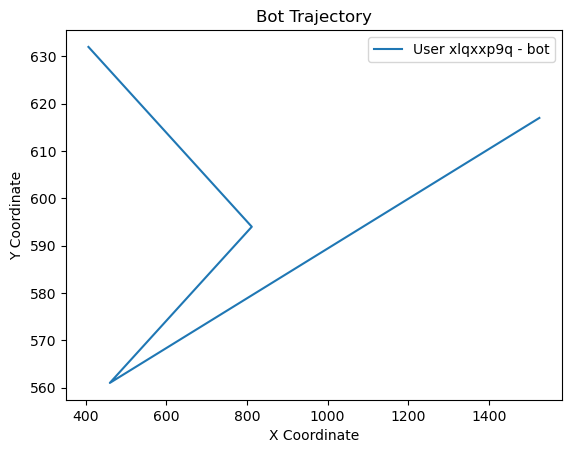

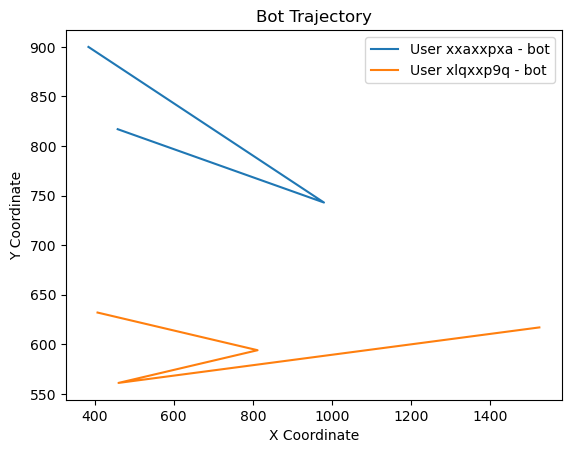

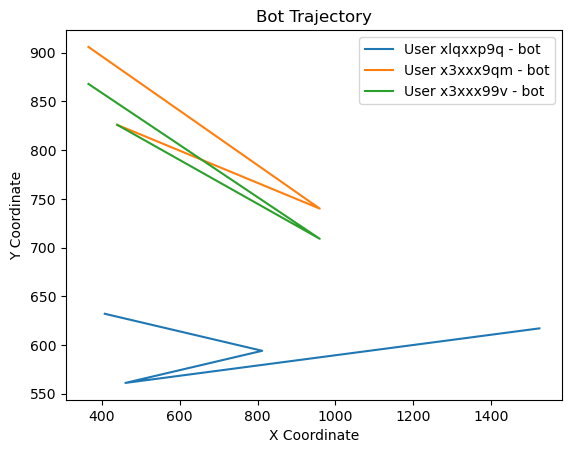

SystemExit: 0

D:\Users\ivan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
import sys
from PyQt5.QtWidgets import QApplication, QWidget, QVBoxLayout, QPushButton, QFileDialog, QLabel, QProgressBar, QTableWidget, QTableWidgetItem
from pandas import read_excel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure

class PlotCanvas(FigureCanvas):
    def __init__(self, parent=None, width=5, height=4, dpi=100):
        fig = Figure(figsize=(width, height), dpi=dpi)
        self.axes = fig.add_subplot(111)
        super(PlotCanvas, self).__init__(fig)

class CoordinateAnalyzerApp(QWidget):
    def __init__(self):
        super().__init__()

        self.df = None
        self.output_df = None
        self.selected_rows = []

        self.init_ui()

    def init_ui(self):
        # Create widgets
        self.load_button = QPushButton('Load Excel File', self)
        self.analyze_button = QPushButton('Analyze Coordinates', self)
        self.save_button = QPushButton('Save Bot DataFrame', self)
        self.plot_button = QPushButton('Plot Selected Rows', self)
        self.info_label = QLabel(self)
        self.progress_bar = QProgressBar(self)
        self.result_table = QTableWidget(self)
        self.plot_canvas = PlotCanvas(self)

        # Set up layout
        layout = QVBoxLayout()
        layout.addWidget(self.load_button)
        layout.addWidget(self.analyze_button)
        layout.addWidget(self.save_button)
        layout.addWidget(self.info_label)
        layout.addWidget(self.progress_bar)
        layout.addWidget(self.result_table)
        layout.addWidget(self.plot_button)
        layout.addWidget(self.plot_canvas)
        self.setLayout(layout)

        # Connect buttons to functions
        self.load_button.clicked.connect(self.load_excel)
        self.analyze_button.clicked.connect(self.analyze_coordinates)
        self.save_button.clicked.connect(self.save_bot_dataframe)
        self.plot_button.clicked.connect(self.plot_selected_rows)

        # Set up the main window
        self.setGeometry(300, 300, 800, 600)
        self.setWindowTitle('Coordinate Analyzer')
        self.show()

    def remove_last_number_and_semicolon(self, line):
        num_digits = self.count_digits_before_last_semicolon(line)
        if line.endswith(","):
            line = line[:-1]  # Remove the last semicolon
        last_comma_index = line.rfind(",")  # Find the last comma index
        if last_comma_index != -1 and line[last_comma_index:].count(";") == 1:
            line = line[:last_comma_index + num_digits + 1]  # Remove the last number and last semicolon

        # Remove comma if it is the last symbol in the line
        if line.endswith(","):
            line = line[:-1]

        return line

    def count_digits_before_last_semicolon(self, line):
        last_semicolon_index = line.rfind(";")
        if last_semicolon_index == -1:
            return 0  # If there is no semicolon in the line, return 0

        before_semicolon = line[:last_semicolon_index]
        last_comma_index = before_semicolon.rfind(",")
        if last_comma_index == -1:
            return 0  # If there is no comma before the last semicolon, return 0

        number_before_semicolon = before_semicolon[last_comma_index + 1:]
        num_digits = sum(1 for char in number_before_semicolon if char.isdigit())
        return num_digits

    def process_coordinate_df(self, input_df, straight_line_threshold=100):
        bot_indexes = []
        human_indexes = []

        total_rows = len(input_df['Массив координат'])
        self.progress_bar.setMaximum(total_rows)
        self.progress_bar.setValue(0)

        for index, cell_value in enumerate(input_df['Массив координат']):
            if pd.isnull(cell_value) or cell_value == "":
                continue  # Skip iteration if the cell value is NaN or empty

            cell_value = self.remove_last_number_and_semicolon(cell_value)
            coord_list = cell_value.split(';')

            # Check if any empty string is present in coord_list
            if any(not coord for coord in coord_list):
                continue  # Skip iteration if an empty string is found

            x_coords = [int(coord.split(',')[0]) for coord in coord_list]
            y_coords = [int(coord.split(',')[1]) for coord in coord_list]

            straight_line_detected = False
            for i in range(2, len(coord_list)):
                x1, y1 = map(int, coord_list[i - 2].split(','))
                x2, y2 = map(int, coord_list[i].split(','))

                if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                    straight_line_detected = True
                    break

            if straight_line_detected:
                human_indexes.append(index)
            else:
                bot_indexes.append(index)

            self.progress_bar.setValue(index + 1)
            QApplication.processEvents()  # Ensure the GUI updates

        max_index = max(max(bot_indexes), max(human_indexes))
        concatenated_list = [1 if i in bot_indexes else 0 if i in human_indexes else np.nan for i in range(max_index + 1)]

        input_df['Bot'] = concatenated_list
        self.output_df = input_df[input_df['Bot'] == 1]  # Retain 'Массив координат' in the output DataFrame
        return self.output_df

    def load_excel(self):
        options = QFileDialog.Options()
        file_name, _ = QFileDialog.getOpenFileName(self, "Open Excel File", "", "Excel Files (*.xlsx);;All Files (*)", options=options)

        if file_name:
            self.df = read_excel(file_name)
            self.info_label.setText(f'Loaded Excel file: {file_name}')
            self.result_table.setRowCount(0)  # Clear existing table when loading a new file

    def analyze_coordinates(self):
        if self.df is not None:
            self.load_button.setEnabled(False)
            self.analyze_button.setEnabled(False)
            self.save_button.setEnabled(False)
            self.plot_button.setEnabled(False)

            self.progress_bar.reset()
            self.result_table.clear()

            # Process coordinates
            self.df = self.process_coordinate_df(self.df)

            # Display resulting table with checkboxes
            self.result_table.setColumnCount(len(self.df.columns))
            self.result_table.setHorizontalHeaderLabels(self.df.columns)
            self.result_table.setRowCount(len(self.df))
            for i, row in enumerate(self.df.itertuples(index=False)):
                for j, value in enumerate(row):
                    item = QTableWidgetItem(str(value))
                    if j == 0:  # Assuming 'Массив координат' is the first column
                        item.setFlags(item.flags() | 0x00001000)  # Add ItemIsUserCheckable flag
                        item.setCheckState(0)  # Initially unchecked
                    self.result_table.setItem(i, j, item)

            self.info_label.setText('Coordinates Analyzed. Select rows to plot.')
            self.plot_button.setEnabled(True)
        else:
            self.info_label.setText('Please load an Excel file first.')

    def save_bot_dataframe(self):
        if self.output_df is not None:
            file_name, _ = QFileDialog.getSaveFileName(self, "Save Bot DataFrame", "", "Excel Files (*.xlsx);;All Files (*)")

            if file_name:
                self.output_df.to_excel(file_name, index=False)
                self.info_label.setText(f'Bot DataFrame saved to: {file_name}')
        else:
            self.info_label.setText('Please analyze coordinates first.')

    def plot_selected_rows(self):
        straight_line_threshold = 100
        self.selected_rows = [i for i in range(self.result_table.rowCount()) if self.result_table.item(i, 0).checkState() == 2]

        if not self.selected_rows:
            self.info_label.setText('No rows selected for plotting.')
        else:
            self.plot_button.setEnabled(False)

            # Plot selected rows
            for row_index in self.selected_rows:
                cell_value = self.df['Массив координат'].iloc[row_index]
                if pd.isnull(cell_value) or cell_value == "":
                    continue  # Skip iteration if the cell value is NaN or empty

                cell_value = self.remove_last_number_and_semicolon(cell_value)
                coord_list = cell_value.split(';')

                # Check if any empty string is present in coord_list
                if any(not coord for coord in coord_list):
                    continue  # Skip iteration if an empty string is found

                # Extract x and y coordinates from each pair
                x_coords = [int(coord.split(',')[0]) for coord in coord_list]
                y_coords = [int(coord.split(',')[1]) for coord in coord_list]

                # Calculate movement patterns
                straight_line_detected = False
                for i in range(2, len(coord_list)):
                    x1, y1 = map(int, coord_list[i - 2].split(','))
                    x2, y2 = map(int, coord_list[i].split(','))

                    # Check if the segment forms a straight line
                    if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                        straight_line_detected = True
                        break

                plt.plot(x_coords, y_coords, label=f"User {self.df['ACCOUNT_ID'].iloc[row_index]} - bot")

            # Add legend and labels
            plt.legend()
            plt.xlabel('X Coordinate')
            plt.ylabel('Y Coordinate')
            plt.title(f'Bot Trajectory')
            plt.show()

            self.plot_button.setEnabled(True)



if __name__ == '__main__':
    app = QApplication(sys.argv)
    ex = CoordinateAnalyzerApp()
    sys.exit(app.exec_())


In [1]:
import sys
from PyQt5.QtWidgets import QApplication, QWidget, QVBoxLayout, QPushButton, QFileDialog, QLabel, QProgressBar, QTableWidget, QTableWidgetItem
from pandas import read_excel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure

class PlotCanvas(FigureCanvas):
    def __init__(self, parent=None, width=5, height=4, dpi=100):
        fig = Figure(figsize=(width, height), dpi=dpi)
        self.axes = fig.add_subplot(111)
        super(PlotCanvas, self).__init__(fig)

class CoordinateAnalyzerApp(QWidget):
    def __init__(self):
        super().__init__()

        self.df = None
        self.output_df = None
        self.selected_rows = []

        self.init_ui()

    def init_ui(self):
        # Create widgets
        self.load_button = QPushButton('Load Excel File', self)
        self.analyze_button = QPushButton('Analyze Coordinates', self)
        self.save_button = QPushButton('Save Bot DataFrame', self)
        self.plot_button = QPushButton('Plot Selected Rows', self)
        self.info_label = QLabel(self)
        self.progress_bar = QProgressBar(self)
        self.result_table = QTableWidget(self)
        self.plot_canvas = PlotCanvas(self)

        # Set up layout
        layout = QVBoxLayout()
        layout.addWidget(self.load_button)
        layout.addWidget(self.analyze_button)
        layout.addWidget(self.save_button)
        layout.addWidget(self.info_label)
        layout.addWidget(self.progress_bar)
        layout.addWidget(self.result_table)
        layout.addWidget(self.plot_button)
        layout.addWidget(self.plot_canvas)
        self.setLayout(layout)

        # Connect buttons to functions
        self.load_button.clicked.connect(self.load_excel)
        self.analyze_button.clicked.connect(self.analyze_coordinates)
        self.save_button.clicked.connect(self.save_bot_dataframe)
        self.plot_button.clicked.connect(self.plot_selected_rows)

        # Set up the main window
        self.setGeometry(300, 300, 800, 600)
        self.setWindowTitle('Coordinate Analyzer')
        self.show()

    def remove_last_number_and_semicolon(self, line):
        num_digits = self.count_digits_before_last_semicolon(line)
        if line.endswith(","):
            line = line[:-1]  # Remove the last semicolon
        last_comma_index = line.rfind(",")  # Find the last comma index
        if last_comma_index != -1 and line[last_comma_index:].count(";") == 1:
            line = line[:last_comma_index + num_digits + 1]  # Remove the last number and last semicolon

        # Remove comma if it is the last symbol in the line
        if line.endswith(","):
            line = line[:-1]

        return line

    def count_digits_before_last_semicolon(self, line):
        last_semicolon_index = line.rfind(";")
        if last_semicolon_index == -1:
            return 0  # If there is no semicolon in the line, return 0

        before_semicolon = line[:last_semicolon_index]
        last_comma_index = before_semicolon.rfind(",")
        if last_comma_index == -1:
            return 0  # If there is no comma before the last semicolon, return 0

        number_before_semicolon = before_semicolon[last_comma_index + 1:]
        num_digits = sum(1 for char in number_before_semicolon if char.isdigit())
        return num_digits

    def process_coordinate_df(self, input_df, straight_line_threshold=100):
        bot_indexes = []
        human_indexes = []

        total_rows = len(input_df['Массив координат'])
        self.progress_bar.setMaximum(total_rows)
        self.progress_bar.setValue(0)

        for index, cell_value in enumerate(input_df['Массив координат']):
            if pd.isnull(cell_value) or cell_value == "":
                continue  # Skip iteration if the cell value is NaN or empty

            cell_value = self.remove_last_number_and_semicolon(cell_value)
            coord_list = cell_value.split(';')

            # Check if any empty string is present in coord_list
            if any(not coord for coord in coord_list):
                continue  # Skip iteration if an empty string is found

            x_coords = [int(coord.split(',')[0]) for coord in coord_list]
            y_coords = [int(coord.split(',')[1]) for coord in coord_list]

            straight_line_detected = False
            for i in range(2, len(coord_list)):
                x1, y1 = map(int, coord_list[i - 2].split(','))
                x2, y2 = map(int, coord_list[i].split(','))

                if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                    straight_line_detected = True
                    break

            if straight_line_detected:
                human_indexes.append(index)
            else:
                bot_indexes.append(index)

            self.progress_bar.setValue(index + 1)
            QApplication.processEvents()  # Ensure the GUI updates

        max_index = max(max(bot_indexes), max(human_indexes))
        concatenated_list = [1 if i in bot_indexes else 0 if i in human_indexes else np.nan for i in range(max_index + 1)]

        input_df['Bot'] = concatenated_list
        self.output_df = input_df[input_df['Bot'] == 1]  # Retain 'Массив координат' in the output DataFrame
        return self.output_df

    def load_excel(self):
        options = QFileDialog.Options()
        file_name, _ = QFileDialog.getOpenFileName(self, "Open Excel File", "", "Excel Files (*.xlsx);;All Files (*)", options=options)

        if file_name:
            self.df = read_excel(file_name)
            self.info_label.setText(f'Loaded Excel file: {file_name}')
            self.result_table.setRowCount(0)  # Clear existing table when loading a new file

    def analyze_coordinates(self):
        if self.df is not None:
            self.load_button.setEnabled(False)
            self.analyze_button.setEnabled(False)
            self.save_button.setEnabled(False)
            self.plot_button.setEnabled(False)

            self.progress_bar.reset()
            self.result_table.clear()

            # Process coordinates
            self.df = self.process_coordinate_df(self.df)

            # Display resulting table with checkboxes
            self.result_table.setColumnCount(len(self.df.columns))
            self.result_table.setHorizontalHeaderLabels(self.df.columns)
            self.result_table.setRowCount(len(self.df))
            for i, row in enumerate(self.df.itertuples(index=False)):
                for j, value in enumerate(row):
                    item = QTableWidgetItem(str(value))
                    if j == 0:  # Assuming 'Массив координат' is the first column
                        item.setFlags(item.flags() | 0x00001000)  # Add ItemIsUserCheckable flag
                        item.setCheckState(0)  # Initially unchecked
                    self.result_table.setItem(i, j, item)

            self.info_label.setText('Coordinates Analyzed. Select rows to plot.')
            self.plot_button.setEnabled(True)
        else:
            self.info_label.setText('Please load an Excel file first.')

    def save_bot_dataframe(self):
        if self.output_df is not None:
            file_name, _ = QFileDialog.getSaveFileName(self, "Save Bot DataFrame", "", "Excel Files (*.xlsx);;All Files (*)")

            if file_name:
                self.output_df.to_excel(file_name, index=False)
                self.info_label.setText(f'Bot DataFrame saved to: {file_name}')
        else:
            self.info_label.setText('Please analyze coordinates first.')

    def plot_selected_rows(self):
        straight_line_threshold = 100
        self.selected_rows = [i for i in range(self.result_table.rowCount()) if self.result_table.item(i, 0).checkState() == 2]

        if not self.selected_rows:
            self.info_label.setText('No rows selected for plotting.')
        else:
            self.plot_button.setEnabled(False)

            # Plot selected rows
            for row_index in self.selected_rows:
                cell_value = self.df['Массив координат'].iloc[row_index]
                if pd.isnull(cell_value) or cell_value == "":
                    continue  # Skip iteration if the cell value is NaN or empty

                cell_value = self.remove_last_number_and_semicolon(cell_value)
                coord_list = cell_value.split(';')

                # Check if any empty string is present in coord_list
                if any(not coord for coord in coord_list):
                    continue  # Skip iteration if an empty string is found

                # Extract x and y coordinates from each pair
                x_coords = [int(coord.split(',')[0]) for coord in coord_list]
                y_coords = [int(coord.split(',')[1]) for coord in coord_list]

                # Calculate movement patterns
                straight_line_detected = False
                for i in range(2, len(coord_list)):
                    x1, y1 = map(int, coord_list[i - 2].split(','))
                    x2, y2 = map(int, coord_list[i].split(','))

                    # Check if the segment forms a straight line
                    if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                        straight_line_detected = True
                        break

                self.plot_canvas.axes.plot(x_coords, y_coords, label=f"User {self.df['ACCOUNT_ID'].iloc[row_index]} - bot")

            # Add legend and labels
            self.plot_canvas.axes.legend()
            self.plot_canvas.axes.set_xlabel('X Coordinate')
            self.plot_canvas.axes.set_ylabel('Y Coordinate')
            self.plot_canvas.axes.set_title(f'Bot Trajectory')

            # Draw the canvas
            self.plot_canvas.draw()

            self.plot_button.setEnabled(True)

if __name__ == '__main__':
    app = QApplication(sys.argv)
    ex = CoordinateAnalyzerApp()
    sys.exit(app.exec_())


SystemExit: 0

D:\Users\ivan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
import sys
from PyQt5.QtWidgets import QApplication, QWidget, QVBoxLayout, QPushButton, QFileDialog, QLabel, QProgressBar, QTableWidget, QTableWidgetItem
from pandas import read_excel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
import os

class PlotCanvas(FigureCanvas):
    def __init__(self, parent=None, width=5, height=4, dpi=100):
        fig = Figure(figsize=(width, height), dpi=dpi)
        self.axes = fig.add_subplot(111)
        super(PlotCanvas, self).__init__(fig)

class CoordinateAnalyzerApp(QWidget):
    def __init__(self):
        super().__init__()

        self.df = None
        self.output_df = None
        self.selected_rows = []
        self.image_folder = 'images'

        self.init_ui()

    def init_ui(self):
        # Create widgets
        self.load_button = QPushButton('Load Excel File', self)
        self.analyze_button = QPushButton('Analyze Coordinates', self)
        self.save_button = QPushButton('Save Bot DataFrame', self)
        self.plot_button = QPushButton('Plot Selected Rows', self)
        self.info_label = QLabel(self)
        self.progress_bar = QProgressBar(self)
        self.result_table = QTableWidget(self)
        self.plot_canvas = PlotCanvas(self)

        # Set up layout
        layout = QVBoxLayout()
        layout.addWidget(self.load_button)
        layout.addWidget(self.analyze_button)
        layout.addWidget(self.save_button)
        layout.addWidget(self.info_label)
        layout.addWidget(self.progress_bar)
        layout.addWidget(self.result_table)
        layout.addWidget(self.plot_button)
        layout.addWidget(self.plot_canvas)
        self.setLayout(layout)

        # Connect buttons to functions
        self.load_button.clicked.connect(self.load_excel)
        self.analyze_button.clicked.connect(self.analyze_coordinates)
        self.save_button.clicked.connect(self.save_bot_dataframe)
        self.plot_button.clicked.connect(self.plot_selected_rows)

        # Set up the main window
        self.setGeometry(300, 300, 800, 600)
        self.setWindowTitle('Coordinate Analyzer')
        self.show()

    def remove_last_number_and_semicolon(self, line):
        num_digits = self.count_digits_before_last_semicolon(line)
        if line.endswith(","):
            line = line[:-1]  # Remove the last semicolon
        last_comma_index = line.rfind(",")  # Find the last comma index
        if last_comma_index != -1 and line[last_comma_index:].count(";") == 1:
            line = line[:last_comma_index + num_digits + 1]  # Remove the last number and last semicolon

        # Remove comma if it is the last symbol in the line
        if line.endswith(","):
            line = line[:-1]

        return line

    def count_digits_before_last_semicolon(self, line):
        last_semicolon_index = line.rfind(";")
        if last_semicolon_index == -1:
            return 0  # If there is no semicolon in the line, return 0

        before_semicolon = line[:last_semicolon_index]
        last_comma_index = before_semicolon.rfind(",")
        if last_comma_index == -1:
            return 0  # If there is no comma before the last semicolon, return 0

        number_before_semicolon = before_semicolon[last_comma_index + 1:]
        num_digits = sum(1 for char in number_before_semicolon if char.isdigit())
        return num_digits

    def process_coordinate_df(self, input_df, straight_line_threshold=100):
        bot_indexes = []
        human_indexes = []

        total_rows = len(input_df['Массив координат'])
        self.progress_bar.setMaximum(total_rows)
        self.progress_bar.setValue(0)

        for index, cell_value in enumerate(input_df['Массив координат']):
            if pd.isnull(cell_value) or cell_value == "":
                continue  # Skip iteration if the cell value is NaN or empty

            cell_value = self.remove_last_number_and_semicolon(cell_value)
            coord_list = cell_value.split(';')

            # Check if any empty string is present in coord_list
            if any(not coord for coord in coord_list):
                continue  # Skip iteration if an empty string is found

            x_coords = [int(coord.split(',')[0]) for coord in coord_list]
            y_coords = [int(coord.split(',')[1]) for coord in coord_list]

            straight_line_detected = False
            for i in range(2, len(coord_list)):
                x1, y1 = map(int, coord_list[i - 2].split(','))
                x2, y2 = map(int, coord_list[i].split(','))

                if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                    straight_line_detected = True
                    break

            if straight_line_detected:
                human_indexes.append(index)
            else:
                bot_indexes.append(index)

            self.progress_bar.setValue(index + 1)
            QApplication.processEvents()  # Ensure the GUI updates

        max_index = max(max(bot_indexes), max(human_indexes))
        concatenated_list = [1 if i in bot_indexes else 0 if i in human_indexes else np.nan for i in range(max_index + 1)]

        input_df['Bot'] = concatenated_list
        self.output_df = input_df[input_df['Bot'] == 1]   # Retain 'Массив координат' in the output DataFrame
        return self.output_df

    def load_excel(self):
        options = QFileDialog.Options()
        file_name, _ = QFileDialog.getOpenFileName(self, "Open Excel File", "", "Excel Files (*.xlsx);;All Files (*)", options=options)

        if file_name:
            self.df = read_excel(file_name)
            self.info_label.setText(f'Loaded Excel file: {file_name}')
            self.result_table.setRowCount(0)  # Clear existing table when loading a new file

    def analyze_coordinates(self):
        if self.df is not None:
            self.load_button.setEnabled(False)
            self.analyze_button.setEnabled(False)
            self.save_button.setEnabled(False)
            self.plot_button.setEnabled(False)

            self.progress_bar.reset()
            self.result_table.clear()

            # Process coordinates
            self.df = self.process_coordinate_df(self.df)

            # Display resulting table with checkboxes
            self.result_table.setColumnCount(len(self.df.columns))
            self.result_table.setHorizontalHeaderLabels(self.df.columns)
            self.result_table.setRowCount(len(self.df))
            for i, row in enumerate(self.df.itertuples(index=False)):
                for j, value in enumerate(row):
                    item = QTableWidgetItem(str(value))
                    if j == 0:  # Assuming 'Массив координат' is the first column
                        item.setFlags(item.flags() | 0x00001000)  # Add ItemIsUserCheckable flag
                        item.setCheckState(0)  # Initially unchecked
                    self.result_table.setItem(i, j, item)

            self.info_label.setText('Coordinates Analyzed. Select rows to plot.')
            self.plot_button.setEnabled(True)

            # Set output_df to the processed DataFrame
            self.output_df = self.df

            # Enable the Save button
            self.save_button.setEnabled(True)
        else:
            self.info_label.setText('Please load an Excel file first.')


    def save_bot_dataframe(self):
        straight_line_threshold = 100
        if self.output_df is not None:
            # Save DataFrame to Excel
            file_name, _ = QFileDialog.getSaveFileName(self, "Save Bot DataFrame", "", "Excel Files (*.xlsx);;All Files (*)")

            if file_name:
                self.output_df.to_excel(file_name, index=False)
                self.info_label.setText(f'Bot DataFrame saved to: {file_name}')

                # Save plots to 'images' folder
                if not os.path.exists(self.image_folder):
                    os.makedirs(self.image_folder)

                for row_index in range(len(self.df)):
                    cell_value = self.df['Массив координат'].iloc[row_index]
                    if pd.isnull(cell_value) or cell_value == "":
                        continue  # Skip iteration if the cell value is NaN or empty

                    cell_value = self.remove_last_number_and_semicolon(cell_value)
                    coord_list = cell_value.split(';')

                    # Check if any empty string is present in coord_list
                    if any(not coord for coord in coord_list):
                        continue  # Skip iteration if an empty string is found

                    # Extract x and y coordinates from each pair
                    x_coords = [int(coord.split(',')[0]) for coord in coord_list]
                    y_coords = [int(coord.split(',')[1]) for coord in coord_list]

                    # Calculate movement patterns
                    straight_line_detected = False
                    for i in range(2, len(coord_list)):
                        x1, y1 = map(int, coord_list[i - 2].split(','))
                        x2, y2 = map(int, coord_list[i].split(','))

                        # Check if the segment forms a straight line
                        if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                            straight_line_detected = True
                            break

                    # Plot and save as JPG
                    if straight_line_detected:
                        plt.plot(x_coords, y_coords, label=f"User {self.df['ACCOUNT_ID'].iloc[row_index]} - Human")
                    else:
                        plt.plot(x_coords, y_coords, label=f"User {self.df['ACCOUNT_ID'].iloc[row_index]} - Bot")

                    # Add legend and labels
                    plt.legend()
                    plt.xlabel('X Coordinate')
                    plt.ylabel('Y Coordinate')
                    plt.title(f'Trajectory {row_index+1}')
                    plt.savefig(os.path.join(self.image_folder, f'trajectory_{row_index+1}.jpg'))
                    plt.clf()  # Clear the figure for the next plot

                self.info_label.setText(f'Plots saved to: {os.path.abspath(self.image_folder)}')
        else:
            self.info_label.setText('Please analyze coordinates first.')

    def plot_selected_rows(self):
        straight_line_threshold = 100
        self.selected_rows = [i for i in range(self.result_table.rowCount()) if self.result_table.item(i, 0).checkState() == 2]

        if not self.selected_rows:
            self.info_label.setText('No rows selected for plotting.')
        else:
            self.plot_button.setEnabled(False)

            # Plot selected rows
            for row_index in self.selected_rows:
                cell_value = self.df['Массив координат'].iloc[row_index]
                if pd.isnull(cell_value) or cell_value == "":
                    continue  # Skip iteration if the cell value is NaN or empty

                cell_value = self.remove_last_number_and_semicolon(cell_value)
                coord_list = cell_value.split(';')

                # Check if any empty string is present in coord_list
                if any(not coord for coord in coord_list):
                    continue  # Skip iteration if an empty string is found

                # Extract x and y coordinates from each pair
                x_coords = [int(coord.split(',')[0]) for coord in coord_list]
                y_coords = [int(coord.split(',')[1]) for coord in coord_list]

                # Calculate movement patterns
                straight_line_detected = False
                for i in range(2, len(coord_list)):
                    x1, y1 = map(int, coord_list[i - 2].split(','))
                    x2, y2 = map(int, coord_list[i].split(','))

                    # Check if the segment forms a straight line
                    if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                        straight_line_detected = True
                        break

                self.plot_canvas.axes.plot(x_coords, y_coords, label=f"User {self.df['ACCOUNT_ID'].iloc[row_index]} - bot")

            # Add legend and labels
            self.plot_canvas.axes.legend()
            self.plot_canvas.axes.set_xlabel('X Coordinate')
            self.plot_canvas.axes.set_ylabel('Y Coordinate')
            self.plot_canvas.axes.set_title(f'Bot Trajectory')

            # Draw the canvas
            self.plot_canvas.draw()

            self.plot_button.setEnabled(True)

if __name__ == '__main__':
    app = QApplication(sys.argv)
    ex = CoordinateAnalyzerApp()
    sys.exit(app.exec_())


SystemExit: 0

D:\Users\ivan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


<Figure size 640x480 with 0 Axes>

In [31]:
from PyQt5.QtWidgets import QApplication, QWidget, QVBoxLayout, QPushButton, QFileDialog, QLabel, QProgressBar, QTableWidget, QTableWidgetItem, QProgressDialog
from PyQt5.QtCore import Qt
from pandas import read_excel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
import os
import sys

class PlotCanvas(FigureCanvas):
    def __init__(self, parent=None, width=5, height=4, dpi=100):
        fig = Figure(figsize=(width, height), dpi=dpi)
        self.axes = fig.add_subplot(111)
        super(PlotCanvas, self).__init__(fig)

class CoordinateAnalyzerApp(QWidget):
    def __init__(self):
        super().__init__()

        self.df = None
        self.output_df = None
        self.selected_rows = []
        self.image_folder = 'images'
        self.image_saving_progress_dialog = None

        self.init_ui()

    def init_ui(self):
        # Create widgets
        self.load_button = QPushButton('Load Excel File', self)
        self.analyze_button = QPushButton('Analyze Coordinates', self)
        self.save_button = QPushButton('Save Bot DataFrame', self)
        self.plot_button = QPushButton('Plot Selected Rows', self)
        self.info_label = QLabel(self)
        self.progress_bar = QProgressBar(self)
        self.result_table = QTableWidget(self)
        self.plot_canvas = PlotCanvas(self)

        # Set up layout
        layout = QVBoxLayout()
        layout.addWidget(self.load_button)
        layout.addWidget(self.analyze_button)
        layout.addWidget(self.save_button)
        layout.addWidget(self.info_label)
        layout.addWidget(self.progress_bar)
        layout.addWidget(self.result_table)
        layout.addWidget(self.plot_button)
        layout.addWidget(self.plot_canvas)
        self.setLayout(layout)

        # Connect buttons to functions
        self.load_button.clicked.connect(self.load_excel)
        self.analyze_button.clicked.connect(self.analyze_coordinates)
        self.save_button.clicked.connect(self.save_bot_dataframe)
        self.plot_button.clicked.connect(self.plot_selected_rows)

        # Set up the main window
        self.setGeometry(300, 300, 800, 600)
        self.setWindowTitle('Coordinate Analyzer')
        self.show()

    def remove_last_number_and_semicolon(self, line):
        num_digits = self.count_digits_before_last_semicolon(line)
        if line.endswith(","):
            line = line[:-1]  # Remove the last semicolon
        last_comma_index = line.rfind(",")  # Find the last comma index
        if last_comma_index != -1 and line[last_comma_index:].count(";") == 1:
            line = line[:last_comma_index + num_digits + 1]  # Remove the last number and last semicolon

        # Remove comma if it is the last symbol in the line
        if line.endswith(","):
            line = line[:-1]

        return line

    def count_digits_before_last_semicolon(self, line):
        last_semicolon_index = line.rfind(";")
        if last_semicolon_index == -1:
            return 0  # If there is no semicolon in the line, return 0

        before_semicolon = line[:last_semicolon_index]
        last_comma_index = before_semicolon.rfind(",")
        if last_comma_index == -1:
            return 0  # If there is no comma before the last semicolon, return 0

        number_before_semicolon = before_semicolon[last_comma_index + 1:]
        num_digits = sum(1 for char in number_before_semicolon if char.isdigit())
        return num_digits

    def process_coordinate_df(self, input_df, straight_line_threshold=100):
        bot_indexes = []
        human_indexes = []

        total_rows = len(input_df['Массив координат'])
        self.progress_bar.setMaximum(total_rows)
        self.progress_bar.setValue(0)

        for index, cell_value in enumerate(input_df['Массив координат']):
            if pd.isnull(cell_value) or cell_value == "":
                continue  # Skip iteration if the cell value is NaN or empty

            cell_value = self.remove_last_number_and_semicolon(cell_value)
            coord_list = cell_value.split(';')

            # Check if any empty string is present in coord_list
            if any(not coord for coord in coord_list):
                continue  # Skip iteration if an empty string is found

            x_coords = [int(coord.split(',')[0]) for coord in coord_list]
            y_coords = [int(coord.split(',')[1]) for coord in coord_list]

            straight_line_detected = False
            for i in range(2, len(coord_list)):
                x1, y1 = map(int, coord_list[i - 2].split(','))
                x2, y2 = map(int, coord_list[i].split(','))

                if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                    straight_line_detected = True
                    break

            if straight_line_detected:
                human_indexes.append(index)
            else:
                bot_indexes.append(index)

            self.progress_bar.setValue(index + 1)
            QApplication.processEvents()  # Ensure the GUI updates

        max_index = max(max(bot_indexes), max(human_indexes))
        concatenated_list = [1 if i in bot_indexes else 0 if i in human_indexes else np.nan for i in range(max_index + 1)]

        input_df['Bot'] = concatenated_list
        self.output_df = input_df[input_df['Bot'] == 1]   # Retain 'Массив координат' in the output DataFrame
        return self.output_df

    def load_excel(self):
        options = QFileDialog.Options()
        file_name, _ = QFileDialog.getOpenFileName(self, "Open Excel File", "", "Excel Files (*.xlsx);;All Files (*)", options=options)

        if file_name:
            self.df = read_excel(file_name)
            self.info_label.setText(f'Loaded Excel file: {file_name}')
            self.result_table.setRowCount(0)  # Clear existing table when loading a new file

    def analyze_coordinates(self):
        if self.df is not None:
            self.load_button.setEnabled(False)
            self.analyze_button.setEnabled(False)
            self.save_button.setEnabled(False)
            self.plot_button.setEnabled(False)

            self.progress_bar.reset()
            self.result_table.clear()

            # Process coordinates
            self.df = self.process_coordinate_df(self.df)

            # Display resulting table with checkboxes
            self.result_table.setColumnCount(len(self.df.columns))
            self.result_table.setHorizontalHeaderLabels(self.df.columns)
            self.result_table.setRowCount(len(self.df))
            for i, row in enumerate(self.df.itertuples(index=False)):
                for j, value in enumerate(row):
                    item = QTableWidgetItem(str(value))
                    if j == 0:  # Assuming 'Массив координат' is the first column
                        item.setFlags(item.flags() | 0x00001000)  # Add ItemIsUserCheckable flag
                        item.setCheckState(0)  # Initially unchecked
                    self.result_table.setItem(i, j, item)

            self.info_label.setText('Coordinates Analyzed. Select rows to plot.')
            self.plot_button.setEnabled(True)

            # Set output_df to the processed DataFrame
            self.output_df = self.df

            # Enable the Save button
            self.save_button.setEnabled(True)
        else:
            self.info_label.setText('Please load an Excel file first.')


    def save_bot_dataframe(self):
        straight_line_threshold = 100
        if self.output_df is not None:
            # Save DataFrame to Excel
            file_name, _ = QFileDialog.getSaveFileName(self, "Save Bot DataFrame", "", "Excel Files (*.xlsx);;All Files (*)")

            if file_name:
                self.output_df.to_excel(file_name, index=False)
                self.info_label.setText(f'Bot DataFrame saved to: {file_name}')

                # Save plots to 'images' folder
                if not os.path.exists(self.image_folder):
                    os.makedirs(self.image_folder)

                # Initialize progress bar for image saving
                total_rows = len(self.df)
                self.image_saving_progress_dialog = QProgressDialog("Saving Images...", "Cancel", 0, total_rows, self)
                self.image_saving_progress_dialog.setWindowTitle('Image Saving Progress')
                self.image_saving_progress_dialog.setWindowModality(Qt.WindowModal)

                for row_index in range(total_rows):
                    if self.image_saving_progress_dialog.wasCanceled():
                        break

                    cell_value = self.df['Массив координат'].iloc[row_index]
                    if pd.isnull(cell_value) or cell_value == "":
                        continue  # Skip iteration if the cell value is NaN or empty

                    cell_value = self.remove_last_number_and_semicolon(cell_value)
                    coord_list = cell_value.split(';')

                    # Check if any empty string is present in coord_list
                    if any(not coord for coord in coord_list):
                        continue  # Skip iteration if an empty string is found

                    # Extract x and y coordinates from each pair
                    x_coords = [int(coord.split(',')[0]) for coord in coord_list]
                    y_coords = [int(coord.split(',')[1]) for coord in coord_list]

                    # Calculate movement patterns
                    straight_line_detected = False
                    for i in range(2, len(coord_list)):
                        x1, y1 = map(int, coord_list[i - 2].split(','))
                        x2, y2 = map(int, coord_list[i].split(','))

                        # Check if the segment forms a straight line
                        if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                            straight_line_detected = True
                            break

                    # Plot and save as JPG
                    if straight_line_detected:
                        plt.plot(x_coords, y_coords, label=f"User {self.df['ACCOUNT_ID'].iloc[row_index]} - Human")
                    else:
                        plt.plot(x_coords, y_coords, label=f"User {self.df['ACCOUNT_ID'].iloc[row_index]} - Bot")

                    # Add legend and labels
                    plt.legend()
                    plt.xlabel('X Coordinate')
                    plt.ylabel('Y Coordinate')
                    plt.title(f'Trajectory {row_index + 1}')
                    plt.savefig(os.path.join(self.image_folder, f'trajectory_{row_index + 1}.jpg'))
                    plt.clf()  # Clear the figure for the next plot

                    # Update the progress bar
                    self.image_saving_progress_dialog.setValue(row_index + 1)

                # Close the progress bar
                self.image_saving_progress_dialog.setValue(total_rows)
                self.image_saving_progress_dialog.close()

                self.info_label.setText(f'Plots saved to: {os.path.abspath(self.image_folder)}')
        else:
            self.info_label.setText('Please analyze coordinates first.')

    def plot_selected_rows(self):
        straight_line_threshold = 100
        self.selected_rows = [i for i in range(self.result_table.rowCount()) if self.result_table.item(i, 0).checkState() == 2]

        if not self.selected_rows:
            self.info_label.setText('No rows selected for plotting.')
        else:
            self.plot_button.setEnabled(False)

            # Plot selected rows
            for row_index in self.selected_rows:
                cell_value = self.df['Массив координат'].iloc[row_index]
                if pd.isnull(cell_value) or cell_value == "":
                    continue  # Skip iteration if the cell value is NaN or empty

                cell_value = self.remove_last_number_and_semicolon(cell_value)
                coord_list = cell_value.split(';')

                # Check if any empty string is present in coord_list
                if any(not coord for coord in coord_list):
                    continue  # Skip iteration if an empty string is found

                # Extract x and y coordinates from each pair
                x_coords = [int(coord.split(',')[0]) for coord in coord_list]
                y_coords = [int(coord.split(',')[1]) for coord in coord_list]

                # Calculate movement patterns
                straight_line_detected = False
                for i in range(2, len(coord_list)):
                    x1, y1 = map(int, coord_list[i - 2].split(','))
                    x2, y2 = map(int, coord_list[i].split(','))

                    # Check if the segment forms a straight line
                    if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                        straight_line_detected = True
                        break

                self.plot_canvas.axes.plot(x_coords, y_coords, label=f"User {self.df['ACCOUNT_ID'].iloc[row_index]} - bot")

            # Add legend and labels
            self.plot_canvas.axes.legend()
            self.plot_canvas.axes.set_xlabel('X Coordinate')
            self.plot_canvas.axes.set_ylabel('Y Coordinate')
            self.plot_canvas.axes.set_title(f'Bot Trajectory')

            # Draw the canvas
            self.plot_canvas.draw()

            self.plot_button.setEnabled(True)

if __name__ == '__main__':
    app = QApplication(sys.argv)
    ex = CoordinateAnalyzerApp()
    sys.exit(app.exec_())


SystemExit: 0

D:\Users\ivan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
from PyQt5.QtWidgets import QApplication, QWidget, QVBoxLayout, QPushButton, QFileDialog, QLabel, QProgressBar, QTableWidget, QTableWidgetItem, QProgressDialog
from PyQt5.QtCore import Qt
from pandas import read_excel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
import os
import sys

class PlotCanvas(FigureCanvas):
    def __init__(self, parent=None, width=5, height=4, dpi=100):
        fig = Figure(figsize=(width, height), dpi=dpi)
        self.axes = fig.add_subplot(111)
        super(PlotCanvas, self).__init__(fig)

class CoordinateAnalyzerApp(QWidget):
    def __init__(self):
        super().__init__()

        self.df = None
        self.output_df = None
        self.selected_rows = []
        self.image_folder = 'images'
        self.image_saving_progress_dialog = None

        self.init_ui()

    def init_ui(self):
        # Create widgets
        self.load_button = QPushButton('Load Excel File', self)
        self.analyze_button = QPushButton('Analyze Coordinates', self)
        self.save_button = QPushButton('Save Bot DataFrame', self)
        self.plot_button = QPushButton('Plot Selected Rows', self)
        self.info_label = QLabel(self)
        self.progress_bar = QProgressBar(self)
        self.result_table = QTableWidget(self)
        self.plot_canvas = PlotCanvas(self)

        # Set up layout
        layout = QVBoxLayout()
        layout.addWidget(self.load_button)
        layout.addWidget(self.analyze_button)
        layout.addWidget(self.save_button)
        layout.addWidget(self.info_label)
        layout.addWidget(self.progress_bar)
        layout.addWidget(self.result_table)
        layout.addWidget(self.plot_button)
        layout.addWidget(self.plot_canvas)
        self.setLayout(layout)

        # Connect buttons to functions
        self.load_button.clicked.connect(self.load_excel)
        self.analyze_button.clicked.connect(self.analyze_coordinates)
        self.save_button.clicked.connect(self.save_bot_dataframe)
        self.plot_button.clicked.connect(self.plot_selected_rows)

        # Set up the main window
        self.setGeometry(300, 300, 800, 600)
        self.setWindowTitle('Coordinate Analyzer')
        self.show()

    def remove_last_number_and_semicolon(self, line):
        num_digits = self.count_digits_before_last_semicolon(line)
        if line.endswith(","):
            line = line[:-1]  # Remove the last semicolon
        last_comma_index = line.rfind(",")  # Find the last comma index
        if last_comma_index != -1 and line[last_comma_index:].count(";") == 1:
            line = line[:last_comma_index + num_digits + 1]  # Remove the last number and last semicolon

        # Remove comma if it is the last symbol in the line
        if line.endswith(","):
            line = line[:-1]

        return line

    def count_digits_before_last_semicolon(self, line):
        last_semicolon_index = line.rfind(";")
        if last_semicolon_index == -1:
            return 0  # If there is no semicolon in the line, return 0

        before_semicolon = line[:last_semicolon_index]
        last_comma_index = before_semicolon.rfind(",")
        if last_comma_index == -1:
            return 0  # If there is no comma before the last semicolon, return 0

        number_before_semicolon = before_semicolon[last_comma_index + 1:]
        num_digits = sum(1 for char in number_before_semicolon if char.isdigit())
        return num_digits

    def process_coordinate_df(self, input_df, straight_line_threshold=100):
        bot_indexes = []
        human_indexes = []

        total_rows = len(input_df['Массив координат'])
        self.progress_bar.setMaximum(total_rows)
        self.progress_bar.setValue(0)

        for index, cell_value in enumerate(input_df['Массив координат']):
            if pd.isnull(cell_value) or cell_value == "":
                continue  # Skip iteration if the cell value is NaN or empty

            cell_value = self.remove_last_number_and_semicolon(cell_value)
            coord_list = cell_value.split(';')

            # Check if any empty string is present in coord_list
            if any(not coord for coord in coord_list):
                continue  # Skip iteration if an empty string is found

            x_coords = [int(coord.split(',')[0]) for coord in coord_list]
            y_coords = [int(coord.split(',')[1]) for coord in coord_list]

            straight_line_detected = False
            for i in range(2, len(coord_list)):
                x1, y1 = map(int, coord_list[i - 2].split(','))
                x2, y2 = map(int, coord_list[i].split(','))

                if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                    straight_line_detected = True
                    break

            if straight_line_detected:
                human_indexes.append(index)
            else:
                bot_indexes.append(index)

            self.progress_bar.setValue(index + 1)
            QApplication.processEvents()  # Ensure the GUI updates

        max_index = max(max(bot_indexes), max(human_indexes))
        concatenated_list = [1 if i in bot_indexes else 0 if i in human_indexes else np.nan for i in range(max_index + 1)]

        input_df['Bot'] = concatenated_list
        self.output_df = input_df[input_df['Bot'] == 1]   # Retain 'Массив координат' in the output DataFrame
        return self.output_df

    def load_excel(self):
        options = QFileDialog.Options()
        file_name, _ = QFileDialog.getOpenFileName(self, "Open Excel File", "", "Excel Files (*.xlsx);;All Files (*)", options=options)

        if file_name:
            self.df = read_excel(file_name)
            self.info_label.setText(f'Loaded Excel file: {file_name}')
            self.result_table.setRowCount(0)  # Clear existing table when loading a new file

    def analyze_coordinates(self):
        if self.df is not None:
            self.load_button.setEnabled(False)
            self.analyze_button.setEnabled(False)
            self.save_button.setEnabled(False)
            self.plot_button.setEnabled(False)

            self.progress_bar.reset()
            self.result_table.clear()

            # Process coordinates
            self.df = self.process_coordinate_df(self.df)

            # Display resulting table with checkboxes
            self.result_table.setColumnCount(len(self.df.columns))
            self.result_table.setHorizontalHeaderLabels(self.df.columns)
            self.result_table.setRowCount(len(self.df))
            for i, row in enumerate(self.df.itertuples(index=False)):
                for j, value in enumerate(row):
                    item = QTableWidgetItem(str(value))
                    if j == 0:  # Assuming 'Массив координат' is the first column
                        item.setFlags(item.flags() | 0x00001000)  # Add ItemIsUserCheckable flag
                        item.setCheckState(0)  # Initially unchecked
                    self.result_table.setItem(i, j, item)

            self.info_label.setText('Coordinates Analyzed. Select rows to plot.')
            self.plot_button.setEnabled(True)

            # Set output_df to the processed DataFrame
            self.output_df = self.df

            # Enable the Save button
            self.save_button.setEnabled(True)
        else:
            self.info_label.setText('Please load an Excel file first.')


    def save_bot_dataframe(self):
        straight_line_threshold = 100
        if self.output_df is not None:
            # Save DataFrame to Excel
            file_name, _ = QFileDialog.getSaveFileName(self, "Save Bot DataFrame", "", "Excel Files (*.xlsx);;All Files (*)")

            if file_name:
                self.output_df.to_excel(file_name, index=False)
                self.info_label.setText(f'Bot DataFrame saved to: {file_name}')

                # Save plots to 'images' folder
                if not os.path.exists(self.image_folder):
                    os.makedirs(self.image_folder)

                # Initialize progress bar for image saving
                total_rows = len(self.df)
                self.image_saving_progress_dialog = QProgressDialog("Saving Images...", "Cancel", 0, total_rows, self)
                self.image_saving_progress_dialog.setWindowTitle('Image Saving Progress')
                self.image_saving_progress_dialog.setWindowModality(Qt.WindowModal)

                for row_index in range(total_rows):
                    if self.image_saving_progress_dialog.wasCanceled():
                        break

                    cell_value = self.df['Массив координат'].iloc[row_index]
                    if pd.isnull(cell_value) or cell_value == "":
                        continue  # Skip iteration if the cell value is NaN or empty

                    cell_value = self.remove_last_number_and_semicolon(cell_value)
                    coord_list = cell_value.split(';')

                    # Check if any empty string is present in coord_list
                    if any(not coord for coord in coord_list):
                        continue  # Skip iteration if an empty string is found

                    # Extract x and y coordinates from each pair
                    x_coords = [int(coord.split(',')[0]) for coord in coord_list]
                    y_coords = [int(coord.split(',')[1]) for coord in coord_list]

                    # Calculate movement patterns
                    straight_line_detected = False
                    for i in range(2, len(coord_list)):
                        x1, y1 = map(int, coord_list[i - 2].split(','))
                        x2, y2 = map(int, coord_list[i].split(','))

                        # Check if the segment forms a straight line
                        if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                            straight_line_detected = True
                            break

                    # Plot and save as JPG
                    if straight_line_detected:
                        plt.plot(x_coords, y_coords, label=f"User {self.df['ACCOUNT_ID'].iloc[row_index]} - Human")
                    else:
                        plt.plot(x_coords, y_coords, label=f"User {self.df['ACCOUNT_ID'].iloc[row_index]} - Bot")

                    # Add legend and labels
                    plt.legend()
                    plt.xlabel('X Coordinate')
                    plt.ylabel('Y Coordinate')
                    plt.title(f'Trajectory {row_index + 1}')
                    plt.savefig(os.path.join(self.image_folder, f'trajectory_{row_index + 1}.jpg'))
                    plt.clf()  # Clear the figure for the next plot

                    # Update the progress bar
                    self.image_saving_progress_dialog.setValue(row_index + 1)

                # Close the progress bar
                self.image_saving_progress_dialog.setValue(total_rows)
                self.image_saving_progress_dialog.close()

                self.info_label.setText(f'Plots saved to: {os.path.abspath(self.image_folder)}')
        else:
            self.info_label.setText('Please analyze coordinates first.')

    def plot_selected_rows(self):
        straight_line_threshold = 100
        self.selected_rows = [i for i in range(self.result_table.rowCount()) if self.result_table.item(i, 0).checkState() == 2]

        if not self.selected_rows:
            self.info_label.setText('No rows selected for plotting.')
        else:
            self.plot_button.setEnabled(False)

            # Plot selected rows
            for row_index in self.selected_rows:
                cell_value = self.df['Массив координат'].iloc[row_index]
                if pd.isnull(cell_value) or cell_value == "":
                    continue  # Skip iteration if the cell value is NaN or empty

                cell_value = self.remove_last_number_and_semicolon(cell_value)
                coord_list = cell_value.split(';')

                # Check if any empty string is present in coord_list
                if any(not coord for coord in coord_list):
                    continue  # Skip iteration if an empty string is found

                # Extract x and y coordinates from each pair
                x_coords = [int(coord.split(',')[0]) for coord in coord_list]
                y_coords = [int(coord.split(',')[1]) for coord in coord_list]

                # Calculate movement patterns
                straight_line_detected = False
                for i in range(2, len(coord_list)):
                    x1, y1 = map(int, coord_list[i - 2].split(','))
                    x2, y2 = map(int, coord_list[i].split(','))

                    # Check if the segment forms a straight line
                    if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                        straight_line_detected = True
                        break

                self.plot_canvas.axes.plot(x_coords, y_coords, label=f"User {self.df['ACCOUNT_ID'].iloc[row_index]} - bot")

            # Add legend and labels
            self.plot_canvas.axes.legend()
            self.plot_canvas.axes.set_xlabel('X Coordinate')
            self.plot_canvas.axes.set_ylabel('Y Coordinate')
            self.plot_canvas.axes.set_title(f'Bot Trajectory')

            # Draw the canvas
            self.plot_canvas.draw()

            self.plot_button.setEnabled(True)

if __name__ == '__main__':
    app = QApplication(sys.argv)
    ex = CoordinateAnalyzerApp()
    sys.exit(app.exec_())


SystemExit: 0

D:\Users\ivan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## UNIX в GUI

In [1]:
from PyQt5.QtWidgets import QApplication, QWidget, QVBoxLayout, QPushButton, QFileDialog, QLabel, QProgressBar, QTableWidget, QTableWidgetItem, QProgressDialog
from PyQt5.QtCore import Qt
from pandas import read_excel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
import os
import sys
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

class PlotCanvas(FigureCanvas):
    def __init__(self, parent=None, width=5, height=4, dpi=100):
        fig = Figure(figsize=(width, height), dpi=dpi)
        self.axes = fig.add_subplot(111)
        super(PlotCanvas, self).__init__(fig)

class CoordinateAnalyzerApp(QWidget):
    def __init__(self):
        super().__init__()

        self.df = None
        self.output_df = None
        self.selected_rows = []
        self.image_folder = 'images'
        self.image_saving_progress_dialog = None

        self.init_ui()

    def init_ui(self):
        # Create widgets
        self.load_button = QPushButton('Load Excel File', self)
        self.analyze_button = QPushButton('Analyze Coordinates', self)
        self.save_button = QPushButton('Save Bot DataFrame', self)
        self.plot_button = QPushButton('Plot Selected Rows', self)
        self.save_plot_button = QPushButton('Save Plot', self)
        self.info_label = QLabel(self)
        self.progress_bar = QProgressBar(self)
        self.result_table = QTableWidget(self)
        self.plot_canvas = PlotCanvas(self)

        # New buttons for statistical DataFrame
        self.create_statistical_df_button = QPushButton('Create Statistical DataFrame', self)
        self.save_statistical_df_button = QPushButton('Save Statistical DataFrame', self)
        self.save_plot_button.clicked.connect(self.save_plot)

        # Set up layout
        layout = QVBoxLayout()
        layout.addWidget(self.load_button)
        layout.addWidget(self.analyze_button)
        layout.addWidget(self.save_button)
        layout.addWidget(self.info_label)
        layout.addWidget(self.progress_bar)
        layout.addWidget(self.result_table)
        layout.addWidget(self.plot_button)
        layout.addWidget(self.plot_canvas)
        layout.addWidget(self.save_plot_button)
        

        # Add the new statistical DataFrame buttons to the layout
        layout.addWidget(self.create_statistical_df_button)
        layout.addWidget(self.save_statistical_df_button)

        self.setLayout(layout)

        # Connect buttons to functions
        self.load_button.clicked.connect(self.load_excel)
        self.analyze_button.clicked.connect(self.analyze_coordinates)
        self.save_button.clicked.connect(self.save_bot_dataframe)
        self.plot_button.clicked.connect(self.plot_selected_rows)

        # Connect new statistical DataFrame buttons to functions
        self.create_statistical_df_button.clicked.connect(self.create_statistical_df)
        self.save_statistical_df_button.clicked.connect(self.save_statistical_df)

        # Set up the main window
        self.setGeometry(300, 300, 800, 600)
        self.setWindowTitle('Coordinate Analyzer')
        self.show()


    def remove_last_number_and_semicolon(self, line):
        if isinstance(line, str):
            num_digits = self.count_digits_before_last_semicolon(line)
            if line.endswith(","):
                line = line[:-1]  # Remove the last semicolon
            last_comma_index = line.rfind(",")  # Find the last comma index
            if last_comma_index != -1 and line[last_comma_index:].count(";") == 1:
                line = line[:last_comma_index + num_digits + 1]  # Remove the last number and last semicolon

            # Remove comma if it is the last symbol in the line
            if line.endswith(","):
                line = line[:-1]

        return line

    def count_digits_before_last_semicolon(self, line):
        if isinstance(line, str):
            last_semicolon_index = line.rfind(";")
            if last_semicolon_index == -1:
                return 0  # If there is no semicolon in the line, return 0

            before_semicolon = line[:last_semicolon_index]
            last_comma_index = before_semicolon.rfind(",")
            if last_comma_index == -1:
                return 0  # If there is no comma before the last semicolon, return 0

            number_before_semicolon = before_semicolon[last_comma_index + 1:]
            num_digits = sum(1 for char in number_before_semicolon if char.isdigit())
            return num_digits

        return 0  # If the input is not a string, return 0
    
    def calculate_distances(self, unix_timestamps, x_coords, y_coords):
        distances = []
        for i in range(1, len(unix_timestamps)):
            distance = np.sqrt((x_coords[i] - x_coords[i - 1]) ** 2 + (y_coords[i] - y_coords[i - 1]) ** 2)
            distances.append(distance)
        distance_sum = sum(distances)
        return distance_sum

    def calculate_speeds(self, unix_timestamps, x_coords, y_coords):
        speeds = []
        for i in range(1, len(unix_timestamps)):
            time_diff = (unix_timestamps[i] - unix_timestamps[i - 1]) / 1000.0  # Convert to seconds
            distance = np.sqrt((x_coords[i] - x_coords[i - 1]) ** 2 + (y_coords[i] - y_coords[i - 1]) ** 2)
            speed = distance / time_diff
            speeds.append(speed)
        return speeds

    def calculate_accelerations(self, unix_timestamps, speeds):
        accelerations = []
        for i in range(1, len(unix_timestamps) - 1):
            time_diff = (unix_timestamps[i + 1] - unix_timestamps[i - 1]) / 1000.0  # Convert to seconds
            acceleration = (speeds[i] - speeds[i - 1]) / time_diff
            accelerations.append(acceleration)
        return accelerations

    def process_unix_column(self, input_df, col_name):
        total_cells = len(input_df)
        self.progress_bar.setMaximum(total_cells)
        self.progress_bar.setValue(0)

        processed_df = input_df.copy()  # Create a new DataFrame to store processed values
        processed_df['Avg_Speed_unix'] = np.nan
        processed_df['Avg_Accelerate_unix'] = np.nan

        for index, cell_value in enumerate(processed_df[col_name]):
            if pd.isnull(cell_value) or not isinstance(cell_value, str):
                continue  # Skip iteration if the cell value is NaN or not a string

            print(f"Processing cell {index} in column {col_name}")

            try:
                cell_value = self.remove_last_number_and_semicolon(cell_value)
                coord_list = cell_value.split(';')

                # Check if any empty string is present in coord_list
                if any(not coord for coord in coord_list):
                    continue  # Skip iteration if an empty string is found

                # Extract x and y coordinates and unix timestamps from each pair
                x_coords = [int(coord.split(',')[0]) for coord in coord_list]
                y_coords = [int(coord.split(',')[1]) for coord in coord_list]

                # Check if there are at least three elements in coord_list
                if len(coord_list[0].split(',')) < 3:
                    print(f"Skipping cell {index} in column {col_name}: Insufficient elements in coord_list")
                    continue

                unix_timestamps = [int(coord.split(',')[2]) for coord in coord_list]

                # Calculate speeds and accelerations
                distances = self.calculate_distances(unix_timestamps, x_coords, y_coords)
                speeds = self.calculate_speeds(unix_timestamps, x_coords, y_coords)
                accelerations = self.calculate_accelerations(unix_timestamps, speeds)

                # Store calculated values in the new DataFrame
                processed_df.at[index, 'Trajectory Length'] = np.nanmean(distances)
                processed_df.at[index, 'Avg_Speed_unix'] = np.nanmean(speeds)
                processed_df.at[index, 'Avg_Accelerate_unix'] = np.nanmean(accelerations)

            except Exception as e:
                print(f"Error processing cell {index} in column {col_name}: {e}")
                continue

            # Update the progress bar
            self.progress_bar.setValue(index + 1)
            QApplication.processEvents()  # Ensure the GUI updates

        return processed_df

    def calculate_session_time(self, input_df, unix_columns):
        processed_df = input_df.copy()  # Create a new DataFrame to store processed values
        processed_df['Session time'] = np.nan

        for index, row in processed_df.iterrows():
            unix_values = [row[col] for col in unix_columns if col in processed_df.columns and not pd.isnull(row[col]) and isinstance(row[col], str)]

            if not unix_values or not unix_values[0]:
                continue

            try:
                # Extract unix timestamps
                unix_timestamps = [int(coord.split(',')[2]) for coord in unix_values[0].split(';')]

                # Check if there are at least two elements in unix_timestamps
                if len(unix_timestamps) < 2:
                    print(f"Skipping row {index}: Insufficient elements in unix_timestamps")
                    continue

                # Calculate session time
                session_time = (max(unix_timestamps) - min(unix_timestamps)) / 1000.0  # Convert to seconds
                processed_df.at[index, 'Session time'] = session_time

            except (ValueError, IndexError) as e:
                print(f"Error processing row {index}: {e}")
                continue
        return processed_df



    def classify_trajectory(self, df, straight_line_threshold=100):
        # Create empty lists to store the indexes
        bot_indexes = []
        human_indexes = []

        # Iterate over each column in the DataFrame
        for col_name in df.columns:
            if 'unix' in col_name:
                # Iterate over each cell in the column
                for index, cell_value in enumerate(df[col_name]):
                    if pd.isnull(cell_value) or not isinstance(cell_value, str):
                        continue  # Skip iteration if the cell value is NaN or not a string

                    cell_value = self.remove_last_number_and_semicolon(cell_value)

                    try:
                        coord_list = cell_value.split(';')
                    except AttributeError:
                        continue  # Skip iteration if the value is not a string

                    # Check if any empty string is present in coord_list
                    if any(not coord for coord in coord_list):
                        continue  # Skip iteration if an empty string is found


                    # Extract x and y coordinates from each pair
                    x_coords = [int(coord.split(',')[0]) for coord in coord_list]
                    y_coords = [int(coord.split(',')[1]) for coord in coord_list]

                    # Calculate movement patterns
                    straight_line_detected = False
                    for i in range(2, len(coord_list)):
                        x1, y1 = map(int, coord_list[i - 2].split(',')[:2])  # Use only the first two values
                        x2, y2 = map(int, coord_list[i].split(',')[:2])       # Use only the first two values

                        # Check if the segment forms a straight line
                        if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                            straight_line_detected = True
                            break

                    # Classify trajectory based on straight line detection
                    if straight_line_detected:
                        trajectory_class = 'Human'
                        human_indexes.append(index)
                    else:
                        trajectory_class = 'Bot'
                        bot_indexes.append(index)

        # Determine the maximum index
        max_index = max(max(bot_indexes), max(human_indexes))
        concatenated_list = [1 if i in bot_indexes else 0 if i in human_indexes else np.nan for i in range(max_index + 1)]

        return concatenated_list
    

    def process_coordinate_df(self, input_df, straight_line_threshold=100):
        
        coordinate_columns = [column for column in input_df.columns if ('координат' in column.lower()) and not 'Кол-во' in column]
        if not coordinate_columns:
            print("No suitable 'unix' column found.")
            return input_df

        # Classify trajectories
        input_df['Bot'] = self.classify_trajectory(input_df)
        #input_df['Trajectory Length'] = input_df.apply(lambda row: self.calculate_trajectory_length(row[coordinate_columns]), axis=1)

        # Calculate session time for all 'unix' columns
        input_df = self.calculate_session_time(input_df, coordinate_columns)
        input_df = self.process_unix_column(input_df, coordinate_columns[0])
        
        # Save results
        self.output_df = input_df#[input_df['Bot'] == 1]
        self.output_df = self.output_df.loc[:, ~self.output_df.columns.str.contains('Unnamed')]
        
        '''if self.output_df is not None:
            # Assuming 'ID', 'Avg_Speed_unix', 'Avg_Accelerate_unix', 'Session time' are columns in output_df
            statistical_df = self.output_df.groupby('ACCOUNT_ID').agg(
                Number_of_Sessions=pd.NamedAgg(column='ID', aggfunc='count'),
                Average_Speed=pd.NamedAgg(column='Avg_Speed_unix', aggfunc='mean'),
                Average_Accelerate=pd.NamedAgg(column='Avg_Accelerate_unix', aggfunc='mean'),
                Total_Session_Time=pd.NamedAgg(column='Session time', aggfunc='mean')
            ).reset_index()

            #statistical_df = statistical_df[statistical_df['Number_of_Sessions'] > 2]
            #statistical_df = statistical_df.sort_values(by='Number_of_Sessions', ascending=False)

            # Display the statistical_df or update your UI as needed
            #print(statistical_df)
            
            user_list = list(self.output_df['ACCOUNT_ID'].unique())
            user_data = []
            for u in range(len(user_list)):
                bb = self.output_df[self.output_df['ACCOUNT_ID'] == user_list[u]]
                user_data.append(bb)

            activity_counts_list = []
            for a in range(len(user_data)):
                ii = self.activity_counts(user_data[a])
                activity_counts_list.append(ii) 

            ratio_list = []
            for r in range(len(activity_counts_list)):
                rr = self.ratio(activity_counts_list[r])
                ratio_list.append(rr) 

            all_curves_list = []
            for q in range(len(user_data)):
                qq = user_data[q].shape[0]
                all_curves_list.append(qq) 

            all_bot_curves_list = []
            for q in range(len(user_data)):
                qq = user_data[q][user_data[q]['Bot'] == 1].shape[0]
                all_bot_curves_list.append(qq) 

            all_bot_days_list = []
            for q in range(len(user_data)):
                qq = self.days_bot_1(user_data[q])
                all_bot_days_list.append(qq) 

            CountsDays_list = []
            for a in range(len(user_data)):
                ii = self.CountsDays(user_data[a])
                CountsDays_list.append(ii)
                
            data_2 = {
                'ACCOUNT_ID': user_list,
                'Bot days ratio': np.divide(all_bot_days_list, CountsDays_list),
                'Bot traj ratio': np.divide(all_bot_curves_list, all_curves_list),
                'Activity': ratio_list
            }

            # Create a DataFrame from the dictionary
            df_2 = pd.DataFrame(data_2)

            # Merge additional statistics with the existing statistical_df
            result_df = pd.merge(statistical_df, df_2, on='ACCOUNT_ID')
            
            data = result_df
            # Assuming 'data' is your DataFrame
            original_data = data.copy()  # Keep a copy of the original DataFrame

            # Drop 'ACCOUNT_ID' column and preprocess data
            data = original_data.drop('ACCOUNT_ID', axis=1)
            data = data.fillna(data.mean())
            data = np.where(np.abs(data) > 10000, 10000 * np.sign(data), data)

            # Standardize the data
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(data)

            # Apply K-means clustering
            kmeans = KMeans(n_clusters=3, random_state=42)
            cluster_labels = kmeans.fit_predict(scaled_data)

            # Convert the DataFrame to a NumPy array to ensure proper indexing
            data_array = original_data.values

            # Assign the cluster labels to the original DataFrame
            original_data['Cluster'] = cluster_labels

            # Display the result_df or update your UI as needed
            #print(result_df)

            self.output_df = original_data#result_df '''

        return self.output_df


    def load_excel(self):
        options = QFileDialog.Options()
        file_name, _ = QFileDialog.getOpenFileName(self, "Open Excel File", "", "Excel Files (*.xlsx);;All Files (*)", options=options)

        if file_name:
            self.df = read_excel(file_name)
            self.info_label.setText(f'Loaded Excel file: {file_name}')
            self.result_table.setRowCount(0)  # Clear existing table when loading a new file

    def analyze_coordinates(self):
        if self.df is not None:
            self.load_button.setEnabled(False)
            self.analyze_button.setEnabled(False)
            self.save_button.setEnabled(False)
            self.plot_button.setEnabled(False)

            self.progress_bar.reset()
            self.result_table.clear()

            # Process coordinates
            self.df = self.process_coordinate_df(self.df)

            # Display resulting table with checkboxes
            self.result_table.setColumnCount(len(self.df.columns))
            self.result_table.setHorizontalHeaderLabels(self.df.columns)
            self.result_table.setRowCount(len(self.df))
            for i, row in enumerate(self.df.itertuples(index=False)):
                for j, value in enumerate(row):
                    item = QTableWidgetItem(str(value))
                    if j == 0:  # Assuming 'Массив координат' is the first column
                        item.setFlags(item.flags() | 0x00001000)  # Add ItemIsUserCheckable flag
                        item.setCheckState(0)  # Initially unchecked
                    self.result_table.setItem(i, j, item)

            self.info_label.setText('Coordinates Analyzed. Select rows to plot.')
            self.plot_button.setEnabled(True)

            # Set output_df to the processed DataFrame
            self.output_df = self.df

            # Enable the Save button
            self.save_button.setEnabled(True)
        else:
            self.info_label.setText('Please load an Excel file first.')


    def save_bot_dataframe(self, traight_line_threshold = 100):
        #straight_line_threshold = 100
        if self.output_df is not None:
            # Save DataFrame to Excel
            file_name, _ = QFileDialog.getSaveFileName(self, "Save Bot DataFrame", "", "Excel Files (*.xlsx);;All Files (*)")

            if file_name:
                self.output_df.to_excel(file_name, index=False)
                self.info_label.setText(f'Bot DataFrame saved to: {file_name}')

                # Save plots to 'images' folder
                if not os.path.exists(self.image_folder):
                    os.makedirs(self.image_folder)

                # Initialize progress bar for image saving
                total_rows = len(self.df)
                self.image_saving_progress_dialog = QProgressDialog("Saving Images...", "Cancel", 0, total_rows, self)
                self.image_saving_progress_dialog.setWindowTitle('Image Saving Progress')
                self.image_saving_progress_dialog.setWindowModality(Qt.WindowModal)

                # Find the column containing 'координат' and not containing 'К-во'
                coordinate_column = None
                for column in self.df.columns:
                    if 'координат' in column.lower() and not 'К-во' in column:
                        coordinate_column = column
                        break

                if coordinate_column is None:
                    self.info_label.setText("No suitable coordinate column found.")
                    return

                for row_index in range(total_rows):
                    if self.image_saving_progress_dialog.wasCanceled():
                        break

                    cell_value = self.df[coordinate_column].iloc[row_index]
                    if pd.isnull(cell_value) or cell_value == "":
                        continue  # Skip iteration if the cell value is NaN or empty

                    cell_value = self.df[coordinate_column].iloc[row_index]

                    # Check if cell_value is a numpy.int64
                    if isinstance(cell_value, np.int64):
                        # Convert to string before splitting
                        cell_value = str(cell_value)

                    if pd.isnull(cell_value) or cell_value == "":
                        continue  # Skip iteration if the cell value is NaN or empty

                    try:
                        coord_list = cell_value.split(';')  
                        # Extract the first two values from each coordinate and convert them to integers
                        x_coords = [int(coord.split(',')[0]) for coord in coord_list]
                        y_coords = [int(coord.split(',')[1]) for coord in coord_list]

                    except (ValueError, IndexError):
                        continue

                    # Check if any empty string is present in coord_list
                    if any(not coord for coord in coord_list):
                        continue  # Skip iteration if an empty string is found


                    # Calculate movement patterns
                    straight_line_detected = False
                    for i in range(2, len(coord_list)):
                        x1, y1 = map(int, coord_list[i - 2].split(','))
                        x2, y2 = map(int, coord_list[i].split(','))

                        # Check if the segment forms a straight line
                        if abs((y2 - y1) * (x_coords[i - 1] - x1) - (x2 - x1) * (y_coords[i - 1] - y1)) < straight_line_threshold:
                            straight_line_detected = True
                            break

                    # Plot and save as JPG
                    if straight_line_detected:
                        plt.plot(x_coords, y_coords, label=f"User {self.df['ACCOUNT_ID'].iloc[row_index]} - Human")
                    else:
                        plt.plot(x_coords, y_coords, label=f"User {self.df['ACCOUNT_ID'].iloc[row_index]} - Bot")

                    # Add legend and labels
                    plt.legend()
                    plt.xlabel('X Coordinate')
                    plt.ylabel('Y Coordinate')
                    plt.title(f'Trajectory {row_index + 1}')
                    plt.savefig(os.path.join(self.image_folder, f'trajectory_{row_index + 1}.jpg'))
                    plt.clf()  # Clear the figure for the next plot

                    # Update the progress bar
                    self.image_saving_progress_dialog.setValue(row_index + 1)

                # Close the progress bar
                self.image_saving_progress_dialog.setValue(total_rows)
                self.image_saving_progress_dialog.close()

                self.info_label.setText(f'Plots saved to: {os.path.abspath(self.image_folder)}')
        else:
            self.info_label.setText('Please analyze coordinates first.')


    def plot_selected_rows(self):
        self.selected_rows = [i for i in range(self.result_table.rowCount()) if self.result_table.item(i, 0).checkState() == 2]

        coordinate_column = None
        for column in self.df.columns:
            if ('координат' in column.lower() or 'unix' in column.lower()) and not 'К-во' in column:
                if self.df[column].astype(str).str.contains(';').any():
                    coordinate_column = column
                    print(coordinate_column)
                    break

        if coordinate_column is None:
            self.info_label.setText("No suitable coordinate column found.")
            return

        if not self.selected_rows:
            self.info_label.setText('No rows selected for plotting.')
        else:
            self.plot_button.setEnabled(False)

            plotted_labels = set()  # Keep track of plotted labels

            # Plot selected rows
            for row_index in self.selected_rows:
                cell_value = self.df[coordinate_column].iloc[row_index]

                # Check if cell_value is a numpy.int64
                if isinstance(cell_value, np.int64):
                    # Convert to string before splitting
                    cell_value = str(cell_value)

                if pd.isnull(cell_value) or cell_value == "":
                    continue  # Skip iteration if the cell value is NaN or empty

                try:
                    coord_list = cell_value.split(';')  
                    # Extract the first two values from each coordinate and convert them to integers
                    x_coords = [int(coord.split(',')[0]) for coord in coord_list]
                    y_coords = [int(coord.split(',')[1]) for coord in coord_list]

                except (ValueError, IndexError):
                    continue

                # Check if any empty string is present in coord_list
                if any(not coord for coord in coord_list):
                    continue  # Skip iteration if an empty string is found

                label = f"User {self.df['ACCOUNT_ID'].iloc[row_index]} - bot"

                # Check if the label has already been plotted
                if label in plotted_labels:
                    continue  # Skip iteration if the label has already been plotted

                self.plot_canvas.axes.plot(x_coords, y_coords, marker='o', linestyle='-', label=label)

                # Add the label to the set of plotted labels
                plotted_labels.add(label)

            # Add legend and labels outside the loop
            self.plot_canvas.axes.legend()
            self.plot_canvas.axes.set_xlabel('X Coordinate')
            self.plot_canvas.axes.set_ylabel('Y Coordinate')
            self.plot_canvas.axes.set_title(f'Bot Trajectory')

            # Draw the canvas
            self.plot_canvas.draw()
            self.plot_button.setEnabled(True)
            self.save_plot_button.setEnabled(True)
    
    def save_plot(self):
        file_name, _ = QFileDialog.getSaveFileName(self, "Save Plot", "", "PNG Files (*.png);;All Files (*)")

        if file_name:
            self.plot_canvas.figure.savefig(file_name)
            self.info_label.setText(f'Plot saved to: {file_name}')


    def CountsDays(self, data):

        data['CREATED'] = pd.to_datetime(data['CREATED'])

        day_counts = data.groupby(pd.Grouper(key='CREATED', freq='D')).size()


        # Convert day_counts Series to DataFrame
        day_counts_df = day_counts.reset_index()
        day_counts_df.columns = ['CREATED', 'Count']

        return day_counts_df.shape[0]

    def activity_counts(self, data):    
        df = pd.DataFrame(data)

        # Convert 'Дата записи' column to datetime type
        df['CREATED'] = pd.to_datetime(df['CREATED'])

        # Set the time window to determine activity (e.g., 5 minutes)
        time_window = pd.Timedelta(minutes=5)
        df_grouped = df.groupby(pd.Grouper(key='CREATED', freq=time_window)).agg({
            'Кол-во координат': ['sum', 'size'],
            'Bot': 'mean'
        }).reset_index()
        # Drop rows where 'Кол-во координат' == 0
        df_grouped = df_grouped[df_grouped['Кол-во координат']['sum'] != 0]

        # Rename the columns to meaningful names
        df_grouped.columns = ['Дата записи', 'Сумма Кол-во координат', 'Число строк', 'Среднее значение Bot']

        df_grouped['Activity'] = df_grouped['Сумма Кол-во координат'] * df_grouped['Число строк'] * df_grouped['Среднее значение Bot']

        return df_grouped #activity_counts_json

    def ratio(self, data):
        df = data

        # Count the number of non-zero values in 'Activity' column
        non_zero_count = df['Activity'][df['Activity'] != 0].count()

        # Calculate the total count of values in 'Activity' column
        total_count = df['Activity'].count()

        # Calculate the ratio between non-zero values and the total count of values
        return round(non_zero_count / total_count, 2)
    
    def days_bot_1(self, data):
        df = pd.DataFrame(data)

        # Convert 'Дата записи' column to datetime type
        df['CREATED'] = pd.to_datetime(df['CREATED'])

        # Filter the DataFrame to only include rows where 'Bot' is equal to 1
        bot_df = df[df['Bot'] == 1.0]

        # Count the number of unique dates where 'Bot' is equal to 1
        return bot_df['CREATED'].dt.date.nunique()

    def create_statistical_df(self):
        if self.output_df is not None:
            # Assuming 'ID', 'Avg_Speed_unix', 'Avg_Accelerate_unix', 'Session time' are columns in output_df
            statistical_df = self.output_df.groupby('ACCOUNT_ID').agg(
                Number_of_Sessions=pd.NamedAgg(column='ID', aggfunc='count'),
                Average_Speed=pd.NamedAgg(column='Avg_Speed_unix', aggfunc='mean'),
                Average_Accelerate=pd.NamedAgg(column='Avg_Accelerate_unix', aggfunc='mean'),
                Total_Session_Time=pd.NamedAgg(column='Session time', aggfunc='mean')
            ).reset_index()

            #statistical_df = statistical_df[statistical_df['Number_of_Sessions'] > 2]
            #statistical_df = statistical_df.sort_values(by='Number_of_Sessions', ascending=False)

            # Display the statistical_df or update your UI as needed
            #print(statistical_df)
            
            user_list = list(self.output_df['ACCOUNT_ID'].unique())
            user_data = []
            for u in range(len(user_list)):
                bb = self.output_df[self.output_df['ACCOUNT_ID'] == user_list[u]]
                user_data.append(bb)

            activity_counts_list = []
            for a in range(len(user_data)):
                ii = self.activity_counts(user_data[a])
                activity_counts_list.append(ii) 

            ratio_list = []
            for r in range(len(activity_counts_list)):
                rr = self.ratio(activity_counts_list[r])
                ratio_list.append(rr) 

            all_curves_list = []
            for q in range(len(user_data)):
                qq = user_data[q].shape[0]
                all_curves_list.append(qq) 

            all_bot_curves_list = []
            for q in range(len(user_data)):
                qq = user_data[q][user_data[q]['Bot'] == 1].shape[0]
                all_bot_curves_list.append(qq) 

            all_bot_days_list = []
            for q in range(len(user_data)):
                qq = self.days_bot_1(user_data[q])
                all_bot_days_list.append(qq) 

            CountsDays_list = []
            for a in range(len(user_data)):
                ii = self.CountsDays(user_data[a])
                CountsDays_list.append(ii)
                
            data_2 = {
                'ACCOUNT_ID': user_list,
                'Bot days ratio': np.divide(all_bot_days_list, CountsDays_list),
                'Bot traj ratio': np.divide(all_bot_curves_list, all_curves_list),
                'Activity': ratio_list
            }

            # Create a DataFrame from the dictionary
            df_2 = pd.DataFrame(data_2)

            # Merge additional statistics with the existing statistical_df
            result_df = pd.merge(statistical_df, df_2, on='ACCOUNT_ID')
            
            data = result_df
            # Assuming 'data' is your DataFrame
            original_data = data.copy()  # Keep a copy of the original DataFrame

            # Drop 'ACCOUNT_ID' column and preprocess data
            data = original_data.drop('ACCOUNT_ID', axis=1)
            data = data.fillna(data.mean())
            data = np.where(np.abs(data) > 10000, 10000 * np.sign(data), data)

            # Standardize the data
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(data)

            # Apply K-means clustering
            kmeans = KMeans(n_clusters=3, random_state=42)
            cluster_labels = kmeans.fit_predict(scaled_data)

            # Convert the DataFrame to a NumPy array to ensure proper indexing
            data_array = original_data.values

            # Assign the cluster labels to the original DataFrame
            original_data['Cluster'] = cluster_labels

            # Display the result_df or update your UI as needed
            #print(result_df)

            self.statistical_df = original_data#result_df 

            #self.statistical_df = statistical_df  # Save the statistical_df in the class for later use
            self.info_label.setText('Statistical DataFrame created.')

        else:
            self.info_label.setText('Please analyze coordinates first.')

    def save_statistical_df(self):
        if hasattr(self, 'statistical_df'):
            # Save statistical_df to Excel
            file_name, _ = QFileDialog.getSaveFileName(self, "Save Statistical DataFrame", "", "Excel Files (*.xlsx);;All Files (*)")

            if file_name:
                self.statistical_df.to_excel(file_name, index=False)
                self.info_label.setText(f'Statistical DataFrame saved to: {file_name}')
        else:
            self.info_label.setText('Please create the Statistical DataFrame first.')

            
if __name__ == '__main__':
    app = QApplication(sys.argv)
    ex = CoordinateAnalyzerApp()
    sys.exit(app.exec_())


Error processing row 13: list index out of range
Error processing row 29: list index out of range
Error processing row 41: list index out of range
Error processing row 44: list index out of range
Error processing row 58: list index out of range
Error processing row 93: list index out of range
Error processing row 135: list index out of range
Error processing row 151: list index out of range
Error processing row 157: list index out of range
Error processing row 163: list index out of range
Error processing row 199: list index out of range
Error processing row 204: list index out of range
Error processing row 221: list index out of range
Error processing row 228: list index out of range
Error processing row 253: list index out of range
Error processing row 266: list index out of range
Error processing row 268: list index out of range
Error processing row 283: list index out of range
Error processing row 300: list index out of range
Error processing row 303: list index out of range
Error 

C:\Users\ivan\AppData\Local\Temp\ipykernel_6800\2602604433.py:129: RuntimeWarning: divide by zero encountered in double_scalars
  speed = distance / time_diff
D:\Users\ivan\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\ivan\AppData\Local\Temp\ipykernel_6800\2602604433.py:129: RuntimeWarning: divide by zero encountered in double_scalars
  speed = distance / time_diff
C:\Users\ivan\AppData\Local\Temp\ipykernel_6800\2602604433.py:129: RuntimeWarning: invalid value encountered in double_scalars
  speed = distance / time_diff


Processing cell 110 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 111 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 112 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 113 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 114 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 115 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 116 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 117 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 118 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
P

Processing cell 212 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 213 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 214 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 215 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 216 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 217 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 218 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 219 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 220 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
P

Processing cell 308 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 309 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 310 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 311 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 312 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 313 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 314 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 315 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 316 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
P

Processing cell 398 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Skipping cell 398 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970): Insufficient elements in coord_list
Processing cell 399 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 400 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 401 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 402 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 403 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 404 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 405 in column Координаты с отпечатком времени в unix формате 

C:\Users\ivan\AppData\Local\Temp\ipykernel_6800\2602604433.py:137: RuntimeWarning: invalid value encountered in double_scalars
  acceleration = (speeds[i] - speeds[i - 1]) / time_diff


Processing cell 505 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 506 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 507 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 508 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 509 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 510 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 511 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 512 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 513 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
P

Processing cell 580 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 581 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 582 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 583 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 584 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 585 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 586 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 587 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 588 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
P

C:\Users\ivan\AppData\Local\Temp\ipykernel_6800\2602604433.py:183: RuntimeWarning: Mean of empty slice
  processed_df.at[index, 'Avg_Accelerate_unix'] = np.nanmean(accelerations)


Processing cell 675 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 676 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 677 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 678 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 679 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 680 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 681 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 682 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 683 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
P

Processing cell 778 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 779 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 780 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 781 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 782 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 783 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 784 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 785 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 786 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
P

Processing cell 879 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 880 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 881 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 882 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 883 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 884 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 885 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 886 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 887 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
P

Processing cell 973 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 974 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 975 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 976 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 977 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 978 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 979 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 980 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 981 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
P

Processing cell 1053 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1054 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1055 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1056 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1057 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1058 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1059 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1060 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1061 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.0

Processing cell 1140 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1141 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1142 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1143 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1144 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1145 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1146 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1147 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1148 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.0

Processing cell 1246 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1247 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1248 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1249 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1250 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1251 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1252 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1253 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1254 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.0

Processing cell 1344 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1345 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1346 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1347 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1348 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1349 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1350 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1351 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1352 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.0

Processing cell 1428 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1429 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1430 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1431 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1432 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1433 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1434 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1435 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1436 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.0

Processing cell 1531 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1532 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1533 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1534 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1535 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1536 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1537 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1538 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1539 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.0

Processing cell 1625 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1626 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1627 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1628 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1629 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1630 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1631 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1632 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1633 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.0

Processing cell 1720 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1721 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1722 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1723 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1724 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1725 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1726 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1727 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1728 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.0

Processing cell 1822 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1823 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1824 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1825 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1826 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1827 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1828 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1829 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1830 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.0

Processing cell 1927 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1928 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1929 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1930 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1931 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1932 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1933 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1934 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)
Processing cell 1935 in column Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.0

C:\Users\ivan\AppData\Local\Temp\ipykernel_6800\2602604433.py:619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CREATED'] = pd.to_datetime(data['CREATED'])
C:\Users\ivan\AppData\Local\Temp\ipykernel_6800\2602604433.py:619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CREATED'] = pd.to_datetime(data['CREATED'])
C:\Users\ivan\AppData\Local\Temp\ipykernel_6800\2602604433.py:619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

C:\Users\ivan\AppData\Local\Temp\ipykernel_6800\2602604433.py:619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CREATED'] = pd.to_datetime(data['CREATED'])
C:\Users\ivan\AppData\Local\Temp\ipykernel_6800\2602604433.py:619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CREATED'] = pd.to_datetime(data['CREATED'])
C:\Users\ivan\AppData\Local\Temp\ipykernel_6800\2602604433.py:619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

D:\Users\ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\ivan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


SystemExit: 0

D:\Users\ivan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


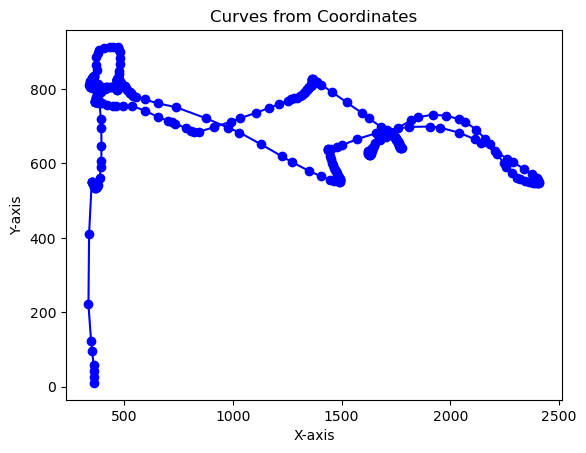

In [6]:
import matplotlib.pyplot as plt

def plot_curves(coord_string):
    # Split the coordinate string into individual coordinates
    coordinates = coord_string.split(';')

    # Extract the first two values from each coordinate and convert them to integers
    x_values = [int(coord.split(',')[0]) for coord in coordinates]
    y_values = [int(coord.split(',')[1]) for coord in coordinates]

    # Plot the curves
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')

    # Add labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Curves from Coordinates')

    # Show the plot
    plt.show()

# Example coordinate string
coordinate_string = df_new['Координаты с отпечатком времени в unix формате (кол-во миллисекунд с 01.01.1970)'][3]#"932,519,1689877037886;989,505,1689877037896;1046,491,1689877037906"

# Call the function to plot curves
plot_curves(coordinate_string)
